# Cell type compositional changes in response to morphogens

>scCODA models cell-type counts using a hierarchical Dirichlet-Multinomial model, which accounts for uncertainty in cell-type proportions and the negative correlative bias via joint modeling of all measured cell-type proportions.(...) The model uses a Logit-normal spike-and-slab prior10 with a log-link function to estimate effects of binary (or continuous) covariates on cell-type proportions in a parsimonious fashion. (...) To ensure a uniquely identifiable solution and easy interpretability, the reference in scCODA is chosen to be a specific cell type. Hence, any detected compositional changes by scCODA always have to be viewed in relation to the selected reference. 
[(Büttner et al., 2021)](https://www.nature.com/articles/s41467-021-27150-6#Sec11)



In [1]:
# import all packages
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import colorcet as cc
import matplotlib.pyplot as plt
import arviz as az
import seaborn as sns

import scanpy as sc
import mudata as mu
import anndata as ad
import os
import gc
import pickle
import gzip

# import pertpy - it takes the gpu resources
import pertpy as pt
sccoda_model = pt.tl.Sccoda()

ryp2 is not installed. Install with pip install rpy2 to run tools with R support.

Global seed set to 0
/home/icb/irena.sliskovic/miniconda3/envs/jax/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:53: LightningDeprecationWarning: pytorch_lightning.utilities.warnings.rank_zero_deprecation has been deprecated in v1.6 and will be removed in v1.8. Use the equivalent function from the pytorch_lightning.utilities.rank_zero module instead.
  new_rank_zero_deprecation(
/home/icb/irena.sliskovic/miniconda3/envs/jax/lib/python3.10/site-packages/pytorch_lightning/utilities/warnings.py:58: LightningDeprecationWarning: The `pytorch_lightning.loggers.base.rank_zero_experiment` is deprecated in v1.7 and will be removed in v1.9. Please use `pytorch_lightning.loggers.logger.rank_zero_experiment` instead.
  return new_rank_zero_deprecation(*args, **kwargs)


In [2]:
# plots settings
%matplotlib inline
palette = sns.color_palette(cc.glasbey_light, n_colors=35)
from matplotlib.colors import ListedColormap
my_cmap = ListedColormap(palette.as_hex())

# function that changes width of bars in barpltos
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

# display all columns
pd.set_option('display.max_columns', None)

# set all relevant paths
path = '/storage/data/data/'
output = '/storage/data/scCODA/plots/'

# define all morphogens
morph_list = pd.DataFrame(['ECM',
                           'ROCK_inhibitor',
                           'BMP_activator',
                           'TGF_B_activator',
                           'TGF_B_inhibitor',
                           'BMP_inhibitor',
                           'WNT_activator',
                           'WNT_inhibitor',
                           'EGF',
                           'FGF2',
                           'FGF8',
                           'SHH_agonist',
                           'RA',
                           'MEK_ERK_inhibitor',
                           'Notch_inhibitor'])

## Preparing the dataset - adding the morphogens

In [ ]:
adata = ad.read_h5ad(os.path.join(path, '230510_08_organoids_labelled.h5ad')) 
adata

In [ ]:
del adata.uns
del adata.obsp
del adata.obsm
del adata.var
adata.obs.drop(columns =['cell_line','development_stage','disease','ethnicity','gm','individual','organism','sex','state_exact',
                         'sample_source','source_doi','suspension_type_original','tech_sample','treatment','assay_sc_original',
                         'cell_line_original','cell_type_original','development_stage_original','disease_original',
                         'ethnicity_original','organ_original','organism_original','sex_original','suspension_type',
                         'obs_names_original','n_genes_by_counts','log1p_n_genes_by_counts','total_counts','log1p_total_counts',
                         'total_counts_mt','log1p_total_counts_mt','pct_counts_mt','leiden_pca_unintegrated_1',
                         'leiden_pca_unintegrated_80','leiden_pca_rss_1','leiden_pca_rss_80','snapseed_pca_unintegrated_level_1',
                         'snapseed_pca_unintegrated_level_2','snapseed_pca_unintegrated_level_3','snapseed_pca_unintegrated_level_4',
                         'snapseed_pca_unintegrated_level_5','snapseed_pca_unintegrated_level_12','snapseed_pca_unintegrated_level_123',
                         'snapseed_pca_unintegrated_level_1234','snapseed_pca_unintegrated_level_12345','snapseed_pca_rss_level_1',
                         'snapseed_pca_rss_level_2','snapseed_pca_rss_level_3','snapseed_pca_rss_level_4','snapseed_pca_rss_level_5',
                         'snapseed_pca_rss_level_12','snapseed_pca_rss_level_1234','snapseed_pca_rss_level_12345','leiden_scpoli_1',
                         'leiden_scpoli_80','snapseed_scpoli_level_2','snapseed_scpoli_level_3','snapseed_scpoli_level_4',
                         'snapseed_scpoli_level_5'])
adata.X = adata.layers['counts'] # using the counts
del adata.layers

In [13]:
morph = pd.read_excel(os.path.join(path,'20230509_morphogens_Incorporate_ hB_ scRNA-seq.xlsx'),
                    sheet_name='Morphogens')
morph = morph.fillna(0)
morph = morph.groupby(['Unnamed: 0']).max()
morph

,"Pasca, 2015 (doi: 10.1038/nmeth.3415)","Birey, 2017 (doi: 10.1038/nature22330)","Lancaster, 2014 (doi: 10.1038/nprot.2014.158)","Marton, 2019 (doi: 10.1038/s41593-018-0316-9)","Trujillo, 2019 (doi: 10.1016/j.stem.2019.08.002)","Velasco, 2019 (doi: 10.1038/s41586-019-1289-x)","Xiang, 2019 (doi: 10.1016/j.stem.2018.12.015)","Yoon, 2019 (doi: 10.1038/s41592-018-0255-0)","Andersen, 2020 (doi: 10.1016/j.cell.2020.11.017); without DAPT","Andersen, 2020 (doi: 10.1016/j.cell.2020.11.017)","Bhaduri, 2020 (doi: 10.1038/s41586-020-1962-0); directed","Bhaduri, 2020 (doi: 10.1038/s41586-020-1962-0); most directed","Miura, 2020 (doi: 10.1038/s41587-020-00763-w)","Pellegrini, 2020 (doi: 10.1126/science.aaz5626); hCO","Pellegrini, 2020 (doi: 10.1126/science.aaz5626); hChPO","Qian, 2020 (doi: 10.1016/j.stem.2020.02.002)","Sawada, 2020 (doi: 10.1038/s41380-020-0844-z)","Fiorenzano, 2021 (doi: 10.1038/s41467-021-27464-5); standard","Fiorenzano, 2021 (doi:10.1038/s41467-021-27464-5); silk+laminin","Fiorenzano, 2021 (doi: 10.1038/s41467-021-27464-5); silk","Huang, 2021 (doi: 10.1016/j.stem.2021.04.006)","Watanabe, 2017 (doi: 10.1016/j.celrep.2017.09.047)","Quadrato, 2017 (doi: 10.1038/protex.2017.049)","Esk, 2020 (doi: 10.1126/science.abb5390)","Quadrato, 2023 (doi: no_doi)","Jo et al., 2016 (doi: 10.1016/j.stem.2016.07.005)","Qian et al., 2016 (doi: 10.1016/j.cell.2016.04.032)"
Unnamed: 0,,,,,,,,,,,,,,,,,,,,,,,,,,,
1-ECM,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,0.0
10-FGF2,1.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
11-FGF8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0
12-SHH agonist,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0
13-RA,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
14-MEK/ERK inhibitor,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15-Notch inhibitor,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2-ROCK inhibitor,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0
3-BMP activator,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
adata.obs['ECM'] = 0
adata.obs['ROCK_inhibitor'] = 0
adata.obs['BMP_activator'] = 0
adata.obs['TGF_B_activator'] = 0
adata.obs['TGF_B_inhibitor'] = 0
adata.obs['BMP_inhibitor'] = 0
adata.obs['WNT_activator'] = 0
adata.obs['WNT_inhibitor'] = 0
adata.obs['EGF'] = 0
adata.obs['FGF2'] = 0
adata.obs['FGF8'] = 0
adata.obs['SHH_agonist'] = 0
adata.obs['RA'] = 0
adata.obs['MEK_ERK_inhibitor'] = 0
adata.obs['Notch_inhibitor'] = 0

assay = pd.DataFrame(morph.columns)
assay

,0
0,"Pasca, 2015 (doi: 10.1038/nmeth.3415)"
1,"Birey, 2017 (doi: 10.1038/nature22330)"
2,"Lancaster, 2014 (doi: 10.1038/nprot.2014.158)"
3,"Marton, 2019 (doi: 10.1038/s41593-018-0316-9)"
4,"Trujillo, 2019 (doi: 10.1016/j.stem.2019.08.002)"
5,"Velasco, 2019 (doi: 10.1038/s41586-019-1289-x)"
6,"Xiang, 2019 (doi: 10.1016/j.stem.2018.12.015)"
7,"Yoon, 2019 (doi: 10.1038/s41592-018-0255-0)"
8,"Andersen, 2020 (doi: 10.1016/j.cell.2020.11.01..."
9,"Andersen, 2020 (doi: 10.1016/j.cell.2020.11.017)"


In [15]:
for i in range(len(assay)):
    adata.obs.loc[adata.obs['assay_differentiation'] == assay.iloc[i][0], 'ECM'] = morph.loc['1-ECM'][assay.iloc[i][0]]
    adata.obs.loc[adata.obs['assay_differentiation'] == assay.iloc[i][0], 'ROCK_inhibitor'] = morph.loc['2-ROCK inhibitor'][assay.iloc[i][0]]
    adata.obs.loc[adata.obs['assay_differentiation'] == assay.iloc[i][0], 'BMP_activator'] = morph.loc['3-BMP activator'][assay.iloc[i][0]]
    adata.obs.loc[adata.obs['assay_differentiation'] == assay.iloc[i][0], 'TGF_B_activator'] = morph.loc['4-TGF-B activator'][assay.iloc[i][0]]
    adata.obs.loc[adata.obs['assay_differentiation'] == assay.iloc[i][0], 'TGF_B_inhibitor'] = morph.loc['5-TGF-B inhibitor'][assay.iloc[i][0]]
    adata.obs.loc[adata.obs['assay_differentiation'] == assay.iloc[i][0], 'BMP_inhibitor'] = morph.loc['6-BMP inhibitor'][assay.iloc[i][0]]
    adata.obs.loc[adata.obs['assay_differentiation'] == assay.iloc[i][0], 'WNT_activator'] = morph.loc['7-WNT activator'][assay.iloc[i][0]]
    adata.obs.loc[adata.obs['assay_differentiation'] == assay.iloc[i][0], 'WNT_inhibitor'] = morph.loc['8-WNT inhibitor'][assay.iloc[i][0]]
    adata.obs.loc[adata.obs['assay_differentiation'] == assay.iloc[i][0], 'EGF'] = morph.loc['9-EGF'][assay.iloc[i][0]]
    adata.obs.loc[adata.obs['assay_differentiation'] == assay.iloc[i][0], 'FGF2'] = morph.loc['10-FGF2'][assay.iloc[i][0]]
    adata.obs.loc[adata.obs['assay_differentiation'] == assay.iloc[i][0], 'FGF8'] = morph.loc['11-FGF8'][assay.iloc[i][0]]
    adata.obs.loc[adata.obs['assay_differentiation'] == assay.iloc[i][0], 'SHH_agonist'] = morph.loc['12-SHH agonist'][assay.iloc[i][0]]
    adata.obs.loc[adata.obs['assay_differentiation'] == assay.iloc[i][0], 'RA'] = morph.loc['13-RA'][assay.iloc[i][0]]
    adata.obs.loc[adata.obs['assay_differentiation'] == assay.iloc[i][0], 'MEK_ERK_inhibitor'] = morph.loc['14-MEK/ERK inhibitor'][assay.iloc[i][0]]
    adata.obs.loc[adata.obs['assay_differentiation'] == assay.iloc[i][0], 'Notch_inhibitor'] = morph.loc['15-Notch inhibitor'][assay.iloc[i][0]]

In [ ]:
adata.obs["bio_sample"] = adata.obs["bio_sample"].astype(str)
# where bio_sample is unknown set it to the id
adata.obs.loc[adata.obs['bio_sample'] == 'unknown', "bio_sample"] = adata[adata.obs['bio_sample'] == 'unknown'].obs.id
adata.obs["bio_sample"] = adata.obs["bio_sample"].astype("category")

In [ ]:
# adding the infromation about morphogens as categorical values
adata.obs['ECM_raw'] = adata.obs['ECM']
adata.obs['ROCK_inhibitor_raw'] = adata.obs['ROCK_inhibitor']
adata.obs['BMP_activator_raw'] = adata.obs['BMP_activator']
adata.obs['TGF_B_activator_raw'] = adata.obs['TGF_B_activator']
adata.obs['TGF_B_inhibitor_raw'] = adata.obs['TGF_B_inhibitor']
adata.obs['BMP_inhibitor_raw'] = adata.obs['BMP_inhibitor']
adata.obs['WNT_activator_raw'] = adata.obs['WNT_activator']
adata.obs['WNT_inhibitor_raw'] = adata.obs['WNT_inhibitor']
adata.obs['EGF_raw'] = adata.obs['EGF']
adata.obs['FGF2_raw'] = adata.obs['FGF2']
adata.obs['FGF8_raw'] = adata.obs['FGF8']
adata.obs['SHH_agonist_raw'] = adata.obs['SHH_agonist']
adata.obs['RA_raw'] = adata.obs['RA']
adata.obs['MEK_ERK_inhibitor_raw'] = adata.obs['MEK_ERK_inhibitor']
adata.obs['Notch_inhibitor_raw'] = adata.obs['Notch_inhibitor']

for i in range(len(morph_list)):
    adata.obs.loc[adata.obs[morph_list.iloc[i][0]]==1, morph_list.iloc[i][0]] = morph_list.iloc[i][0]
    adata.obs.loc[adata.obs[morph_list.iloc[i][0]]==0, morph_list.iloc[i][0]] = "None"
    adata.obs[morph_list.iloc[i][0]] = adata.obs[morph_list.iloc[i][0]].astype("category")
    adata.obs[morph_list.iloc[i][0]] = adata.obs[morph_list.iloc[i][0]].cat.reorder_categories(["None", morph_list.iloc[i][0]])

In [ ]:
morph_orga = adata.obs[['ECM_raw', 'ROCK_inhibitor_raw','BMP_activator_raw','TGF_B_activator_raw','TGF_B_inhibitor_raw','BMP_inhibitor_raw','WNT_activator_raw', 
          'WNT_inhibitor_raw','EGF_raw','FGF2_raw','FGF8_raw','SHH_agonist_raw','RA_raw', 'MEK_ERK_inhibitor_raw','Notch_inhibitor_raw']]
morph_orga.to_csv(os.path.join(path_morph,'230523_morphogens_obs.csv'))

In [ ]:
# adding the final annotation
annot = pd.read_csv(os.path.join(path_morph, "metadata_0620.tsv"),sep='\t')
annot_man = annot[["manual_annot_ct","manual_annot_ct_fine","manual_annot_region","final_region2","final_class"]]

for i in range(len(annot_man)):
    if annot_man['final_region2'][i]=="Unspecific":
        annot_man['final_region2'][i] = annot_man['final_class'][i]

adata.obs[["manual_annot_ct","manual_annot_ct_fine","manual_annot_region","scCODA_region","final_class"]] = annot_man

In [ ]:
# add the information about SHH agonist in Wantabe protocol (it had merged organoids with and without SHH agonist)
adata.obs['SHH_agonist_raw'] = np.where(adata.obs['assay_differentiation']=='Watanabe, 2017 (doi: 10.1016/j.celrep.2017.09.047)', 1, 0)
adata.obs['SHH_agonist'] = np.where(adata.obs['assay_differentiation']=='Watanabe, 2017 (doi: 10.1016/j.celrep.2017.09.047)', "SHH_agonist", "None")

In [36]:
adata.obs

,assay_sc,assay_differentiation,assay_type_differentiation,bio_sample,cell_type,id,organ,organoid_age_days,publication,doi,batch,snapseed_scpoli_level_1,snapseed_scpoli_level_12,snapseed_scpoli_level_123,snapseed_scpoli_level_1234,snapseed_scpoli_level_12345,ECM,ROCK_inhibitor,BMP_activator,TGF_B_activator,TGF_B_inhibitor,BMP_inhibitor,WNT_activator,WNT_inhibitor,EGF,FGF2,FGF8,SHH_agonist,RA,MEK_ERK_inhibitor,Notch_inhibitor,ECM_raw,ROCK_inhibitor_raw,BMP_activator_raw,TGF_B_activator_raw,TGF_B_inhibitor_raw,BMP_inhibitor_raw,WNT_activator_raw,WNT_inhibitor_raw,EGF_raw,FGF2_raw,FGF8_raw,SHH_agonist_raw,RA_raw,MEK_ERK_inhibitor_raw,Notch_inhibitor_raw,manual_annot_ct,manual_annot_ct_fine,manual_annot_region,scCODA_region,final_class
homosapiens_hindbrain_2020_bdrhapsodywholetranscriptomeanalysis_andersenjimena_001_d10_1016_j_cell_2020_11_017_53,BD Rhapsody Whole Transcriptome Analysis,"Andersen, 2020 (doi: 10.1016/j.cell.2020.11.017)",guided,homosapiens_hindbrain_2020_bdrhapsodywholetran...,unknown,homosapiens_hindbrain_2020_bdrhapsodywholetran...,hindbrain,45,"Andersen, 2020",10.1016/j.cell.2020.11.017,homosapiens_hindbrain_2020_bdrhapsodywholetran...,neural_progenitor_cell,diencephalic_npc,thalamic_npc,thalamic_npc,thalamic_npc,None,None,None,None,TGF_B_inhibitor,BMP_inhibitor,WNT_activator,None,EGF,FGF2,None,None,RA,None,Notch_inhibitor,0,0,0,0,1,1,1,0,1,1,0,0,1,0,1,dien./mesen. NPC,dien./mesen. NPC,non-telen.,Medulla,NPC
homosapiens_hindbrain_2020_bdrhapsodywholetranscriptomeanalysis_andersenjimena_001_d10_1016_j_cell_2020_11_017_69,BD Rhapsody Whole Transcriptome Analysis,"Andersen, 2020 (doi: 10.1016/j.cell.2020.11.017)",guided,homosapiens_hindbrain_2020_bdrhapsodywholetran...,unknown,homosapiens_hindbrain_2020_bdrhapsodywholetran...,hindbrain,45,"Andersen, 2020",10.1016/j.cell.2020.11.017,homosapiens_hindbrain_2020_bdrhapsodywholetran...,neural_progenitor_cell,rhombencephalic_npc,medullary_npc,medullary_npc,medullary_npc,None,None,None,None,TGF_B_inhibitor,BMP_inhibitor,WNT_activator,None,EGF,FGF2,None,None,RA,None,Notch_inhibitor,0,0,0,0,1,1,1,0,1,1,0,0,1,0,1,hindbrain NPC,hindbrain NPC,non-telen.,Medulla,NPC
homosapiens_hindbrain_2020_bdrhapsodywholetranscriptomeanalysis_andersenjimena_001_d10_1016_j_cell_2020_11_017_72,BD Rhapsody Whole Transcriptome Analysis,"Andersen, 2020 (doi: 10.1016/j.cell.2020.11.017)",guided,homosapiens_hindbrain_2020_bdrhapsodywholetran...,unknown,homosapiens_hindbrain_2020_bdrhapsodywholetran...,hindbrain,45,"Andersen, 2020",10.1016/j.cell.2020.11.017,homosapiens_hindbrain_2020_bdrhapsodywholetran...,neuron,excitatory_neuron,non_telencephalic_excitatory_neuron,rhombencephalic_excitatory_neuron,cerebellar_excitatory_neuron,None,None,None,None,TGF_B_inhibitor,BMP_inhibitor,WNT_activator,None,EGF,FGF2,None,None,RA,None,Notch_inhibitor,0,0,0,0,1,1,1,0,1,1,0,0,1,0,1,non-telen. N,non-telen. early N,non-telen.,Medulla,neuron
homosapiens_hindbrain_2020_bdrhapsodywholetranscriptomeanalysis_andersenjimena_001_d10_1016_j_cell_2020_11_017_76,BD Rhapsody Whole Transcriptome Analysis,"Andersen, 2020 (doi: 10.1016/j.cell.2020.11.017)",guided,homosapiens_hindbrain_2020_bdrhapsodywholetran...,unknown,homosapiens_hindbrain_2020_bdrhapsodywholetran...,hindbrain,45,"Andersen, 2020",10.1016/j.cell.2020.11.017,homosapiens_hindbrain_2020_bdrhapsodywholetran...,neural_progenitor_cell,diencephalic_npc,thalamic_npc,thalamic_npc,thalamic_npc,None,None,None,None,TGF_B_inhibitor,BMP_inhibitor,WNT_activator,None,EGF,FGF2,None,None,RA,None,Notch_inhibitor,0,0,0,0,1,1,1,0,1,1,0,0,1,0,1,hindbrain NPC,hindbrain NPC,non-telen.,Pons,NPC
homosapiens_hindbrain_2020_bdrhapsodywholetranscriptomeanalysis_andersenjimena_001_d10_1016_j_cell_2020_11_017_78,BD Rhapsody Whole Transcriptome Analysis,"Andersen, 2020 (doi: 10.1016/j.cell.2020.11.017)",guided,homosapiens_hindbrain_2020_bdrhapsodywholetran...,unknown,homosapiens_hindbrain_2020_bdrhapsodywholetran...,hindbrain,45,"Andersen, 2020",10.1016/j.cell.2020.11.017,homosapiens_hindbra

* CP - choroid plexus; MC - mesenchyme; OPC - oligedendrite progenitor cells; EC - endothelial cell; PSC - pluripotent stem cells

In [ ]:
adata.write(os.path.join(path, "230628_organoids_processed_labelled_reduced_morphogens_raw_norm.h5ad"))

In [15]:
# remove PSC and neuroepithelium - displays only the early stage points
adata = adata[adata.obs['scCODA_region']!='PSC'] 
adata = adata[adata.obs['scCODA_region']!='neuroepithelium']

In [16]:
adata.obs['scCODA_region'].value_counts()

scCODA_region
Dorsal telencephalon     757626
Ventral telencephalon    158506
Medulla                  136526
Cerebellum                94494
glioblast                 79506
CP                        77315
Thalamus                  75016
Hypothalamus              70103
Pons                      63328
MC                        49273
astrocyte                 48956
Dorsal midbrain           30651
Ventral midbrain          14759
NC derivatives             9771
OPC                        8325
EC                         2451
microglia                    96
Name: count, dtype: int64

## Cell composition analysis with scCODA 

### Prepare the data

In [17]:
sccoda_data_reg = sccoda_model.load(adata, 
                                type="cell_level", 
                                generate_sample_level=True, 
                                cell_type_identifier="scCODA_region",  
                                sample_identifier="bio_sample", 
                                covariate_obs=['ECM',
                                               'ROCK_inhibitor',
                                               'BMP_activator',
                                               'TGF_B_activator',
                                               'TGF_B_inhibitor',
                                               'BMP_inhibitor',
                                               'WNT_activator',
                                               'WNT_inhibitor',
                                               'EGF',
                                               'FGF2',
                                               'FGF8',
                                               'SHH_agonist',
                                               'RA',
                                               'MEK_ERK_inhibitor',
                                               'Notch_inhibitor'])
print(sccoda_data_reg)

MuData object with n_obs × n_vars = 1677012 × 36859
  2 modalities
    rna:	1676702 x 36842
      obs:	'assay_sc', 'assay_differentiation', 'assay_type_differentiation', 'bio_sample', 'cell_type', 'id', 'organ', 'organoid_age_days', 'publication', 'doi', 'batch', 'snapseed_scpoli_level_1', 'snapseed_scpoli_level_12', 'snapseed_scpoli_level_123', 'snapseed_scpoli_level_1234', 'snapseed_scpoli_level_12345', 'ECM', 'ROCK_inhibitor', 'BMP_activator', 'TGF_B_activator', 'TGF_B_inhibitor', 'BMP_inhibitor', 'WNT_activator', 'WNT_inhibitor', 'EGF', 'FGF2', 'FGF8', 'SHH_agonist', 'RA', 'MEK_ERK_inhibitor', 'Notch_inhibitor', 'ECM_raw', 'ROCK_inhibitor_raw', 'BMP_activator_raw', 'TGF_B_activator_raw', 'TGF_B_inhibitor_raw', 'BMP_inhibitor_raw', 'WNT_activator_raw', 'WNT_inhibitor_raw', 'EGF_raw', 'FGF2_raw', 'FGF8_raw', 'SHH_agonist_raw', 'RA_raw', 'MEK_ERK_inhibitor_raw', 'Notch_inhibitor_raw', 'manual_annot_ct', 'manual_annot_ct_fine', 'manual_annot_region', 'scCODA_region', 'final_class', 'sc

In [ ]:
sccoda_data_reg.write_h5mu(os.path.join(path, 'scCODA_load_model_organoid_all_morphogens_bio-sample_region'))

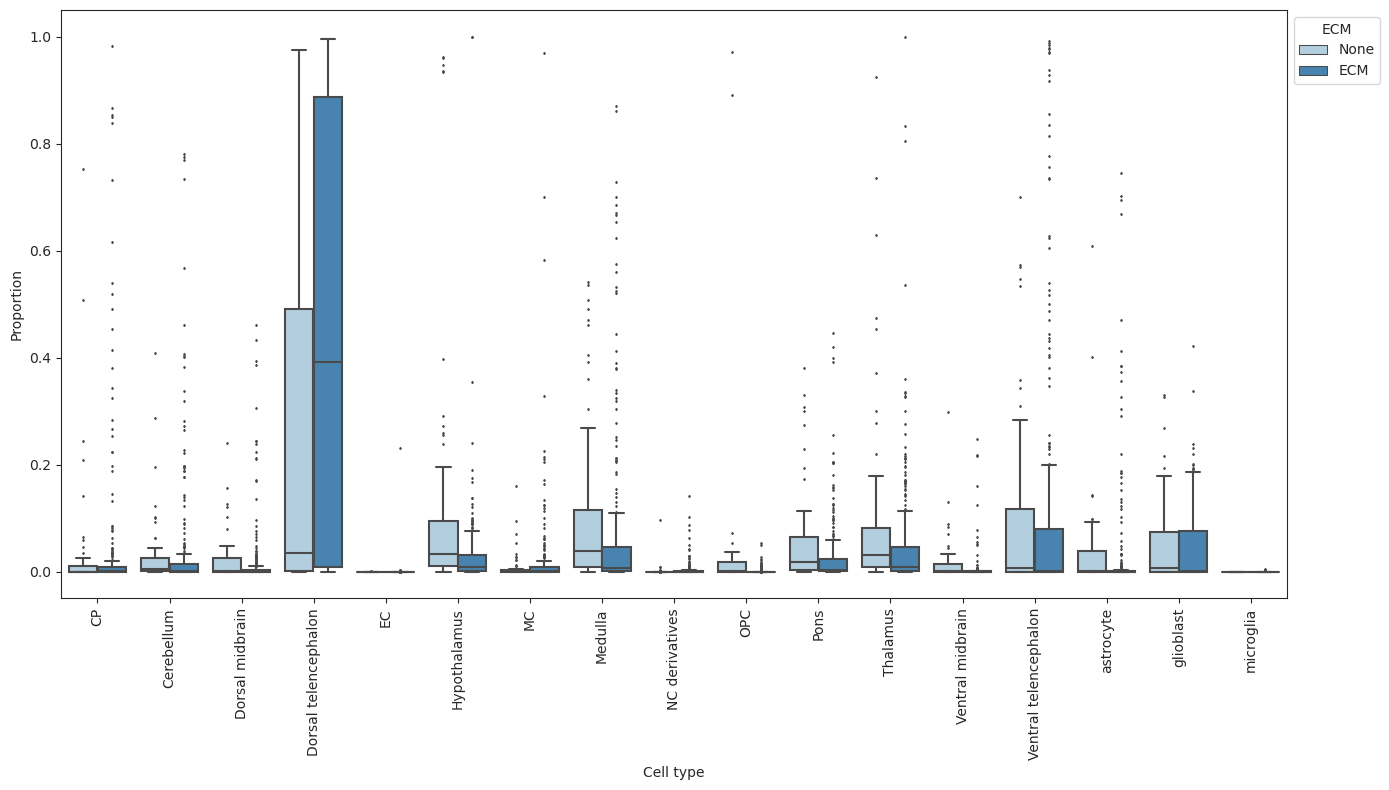

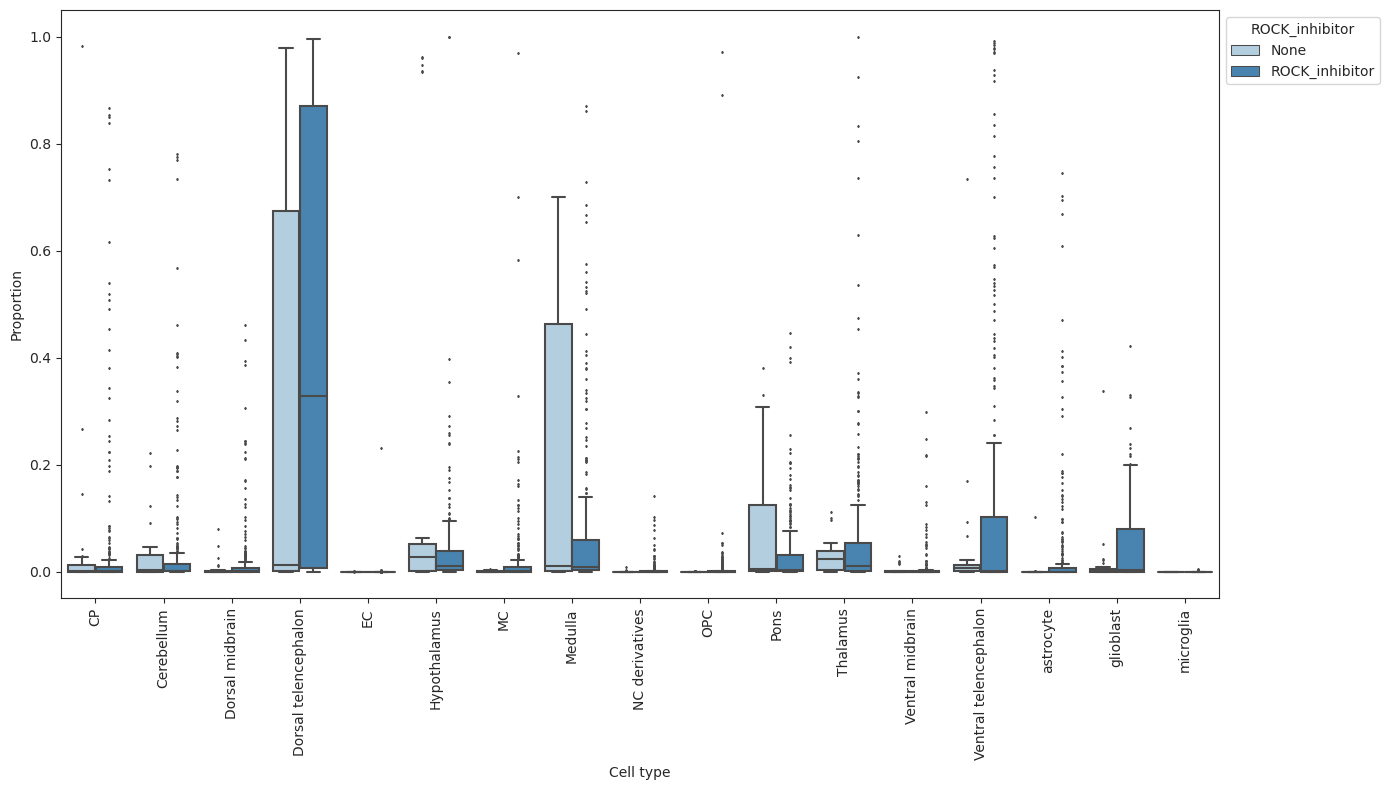

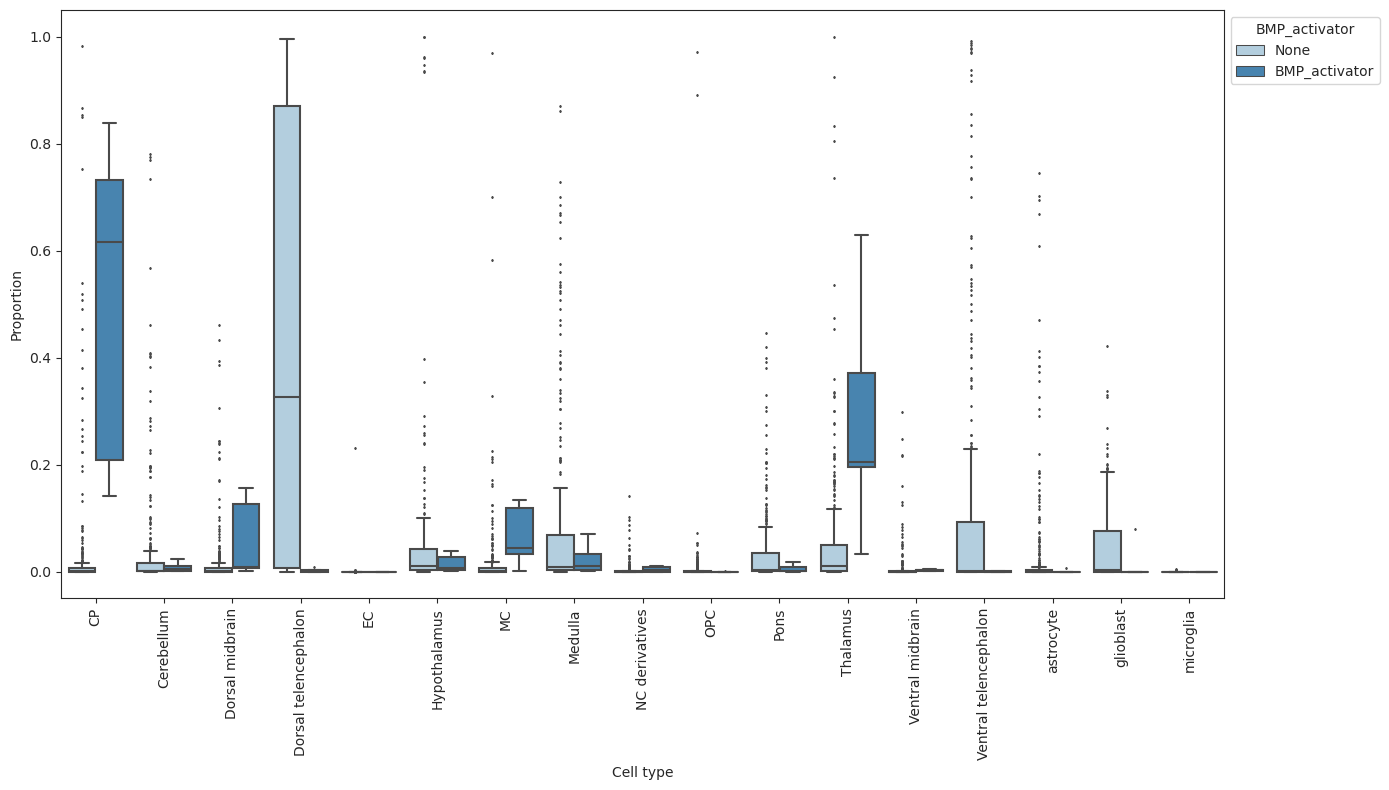

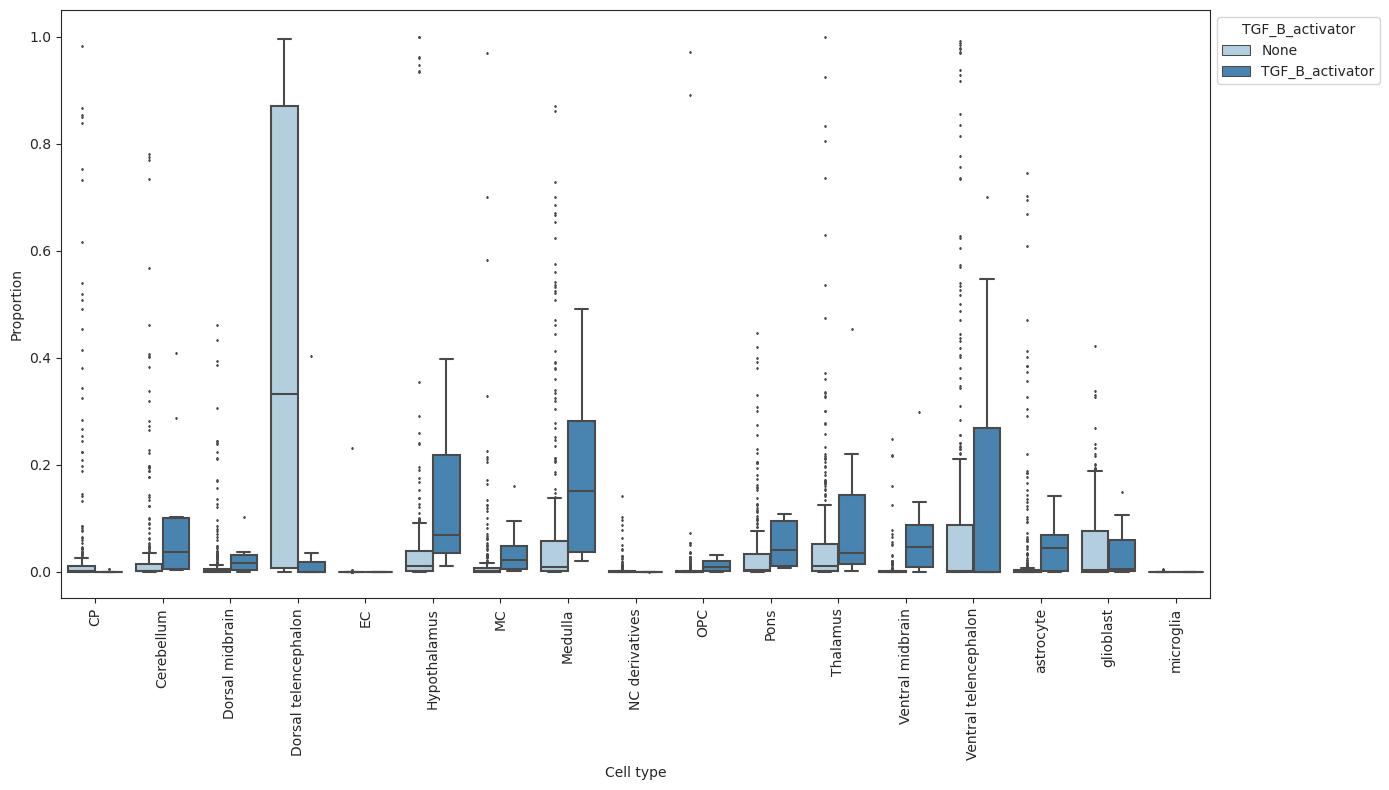

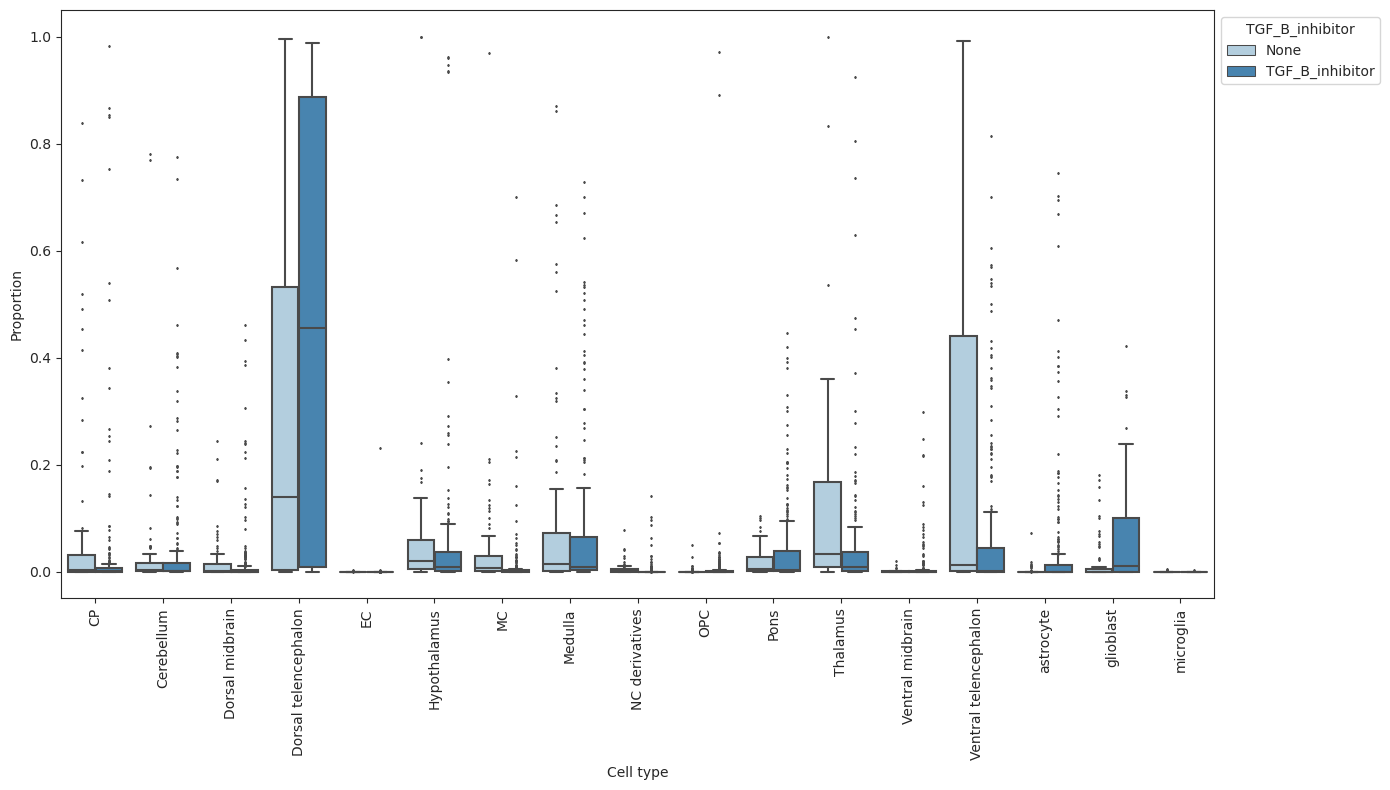

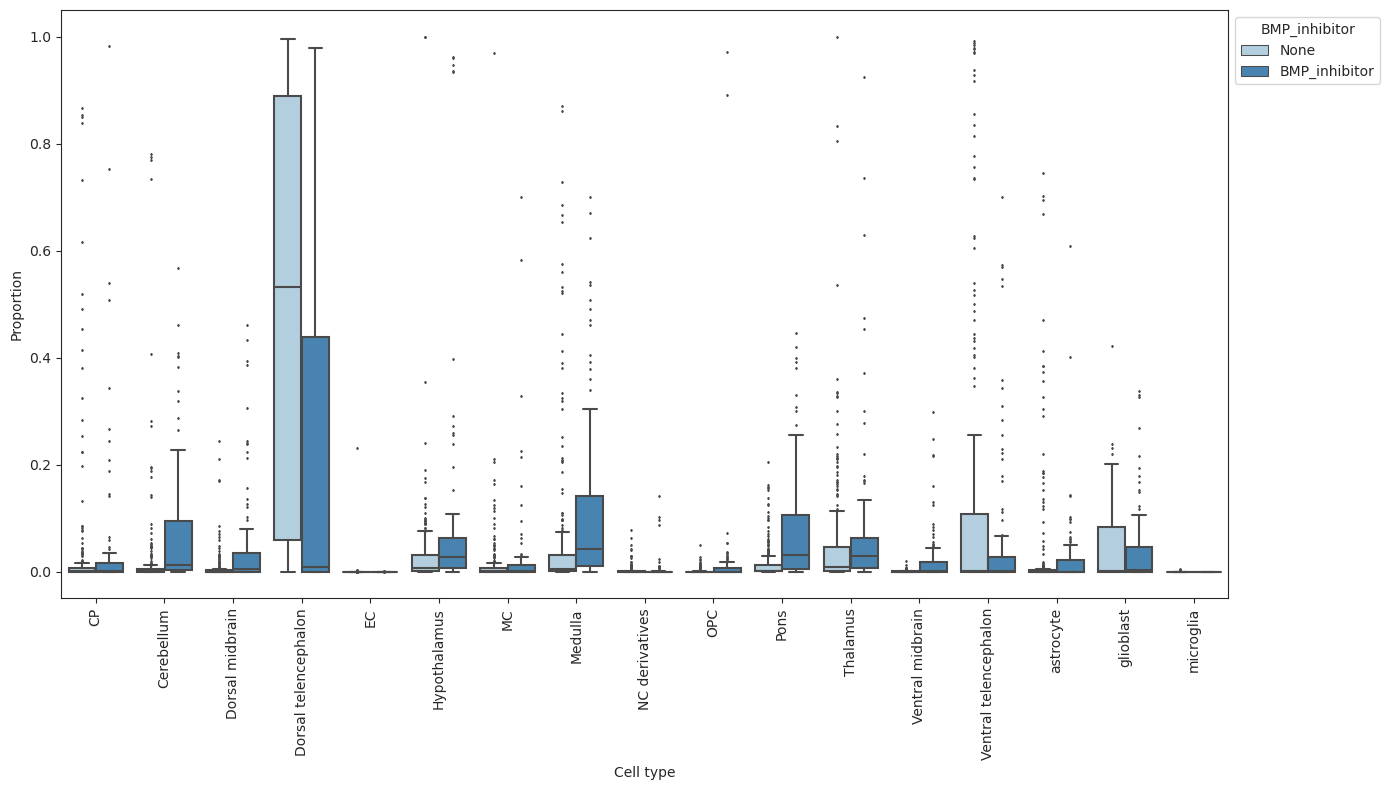

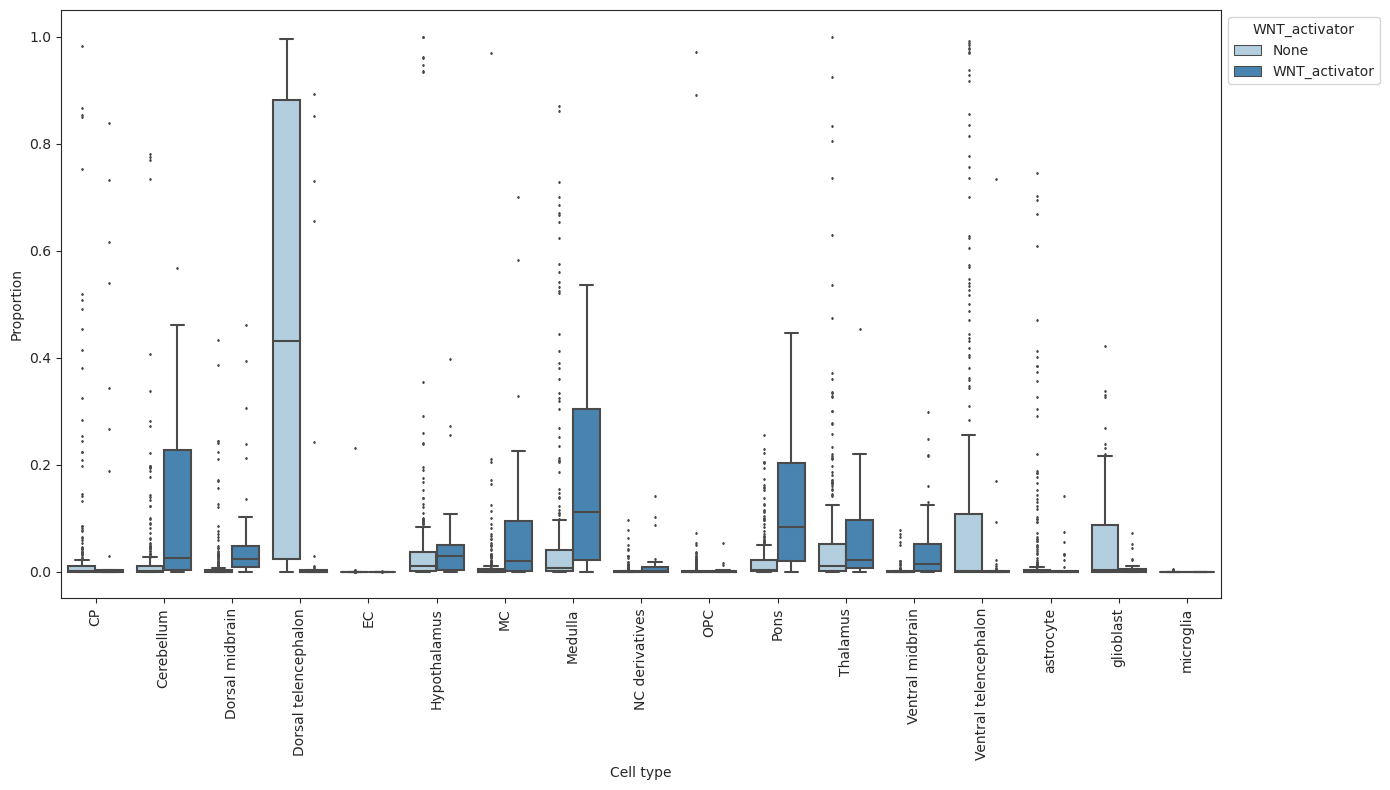

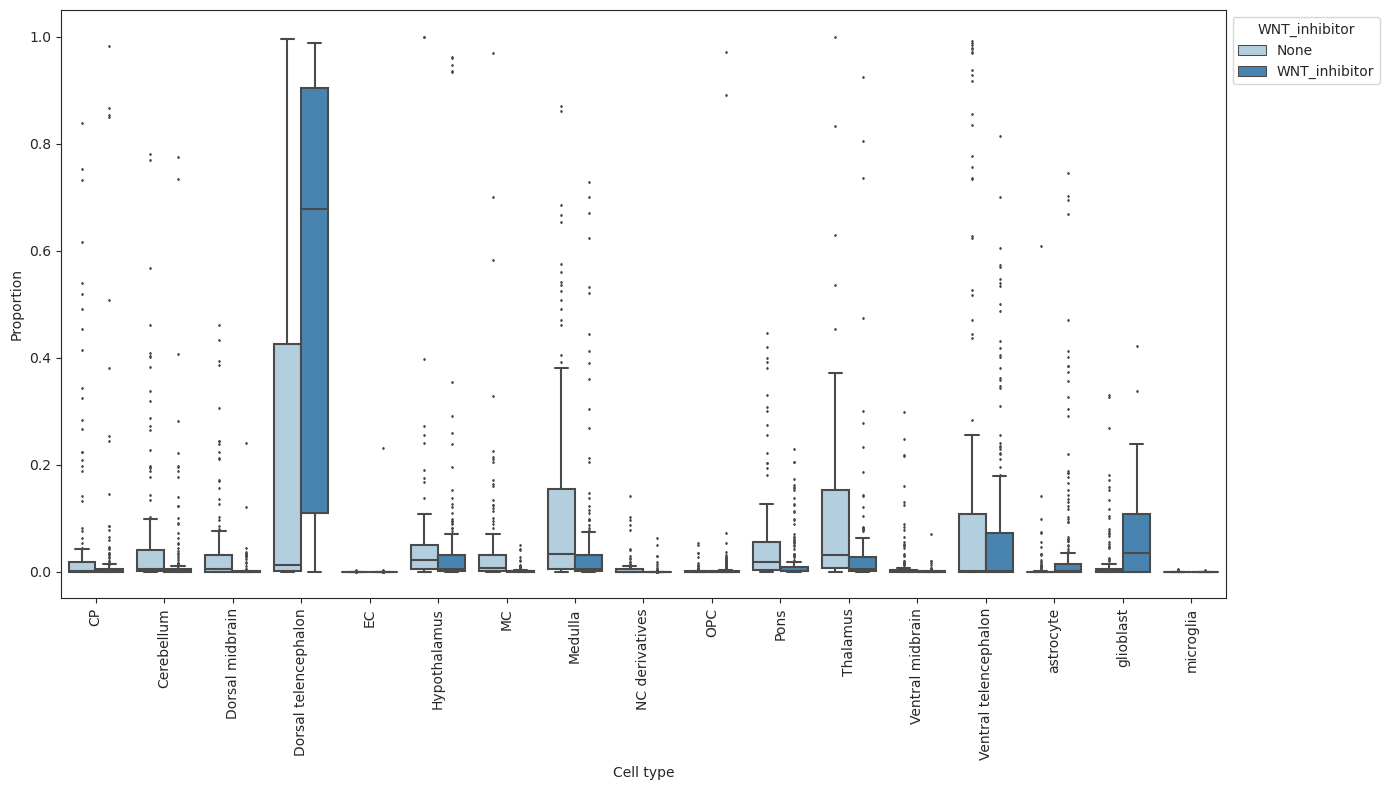

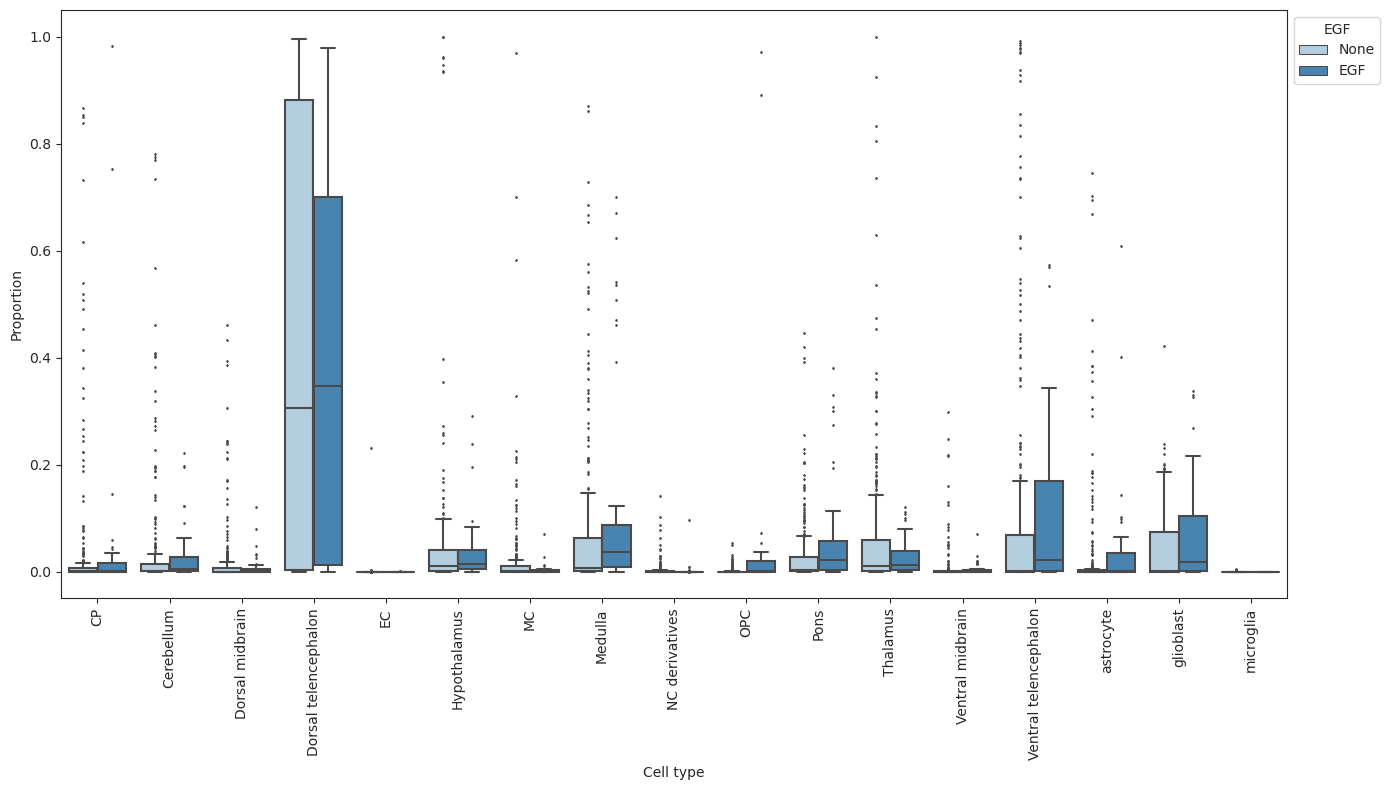

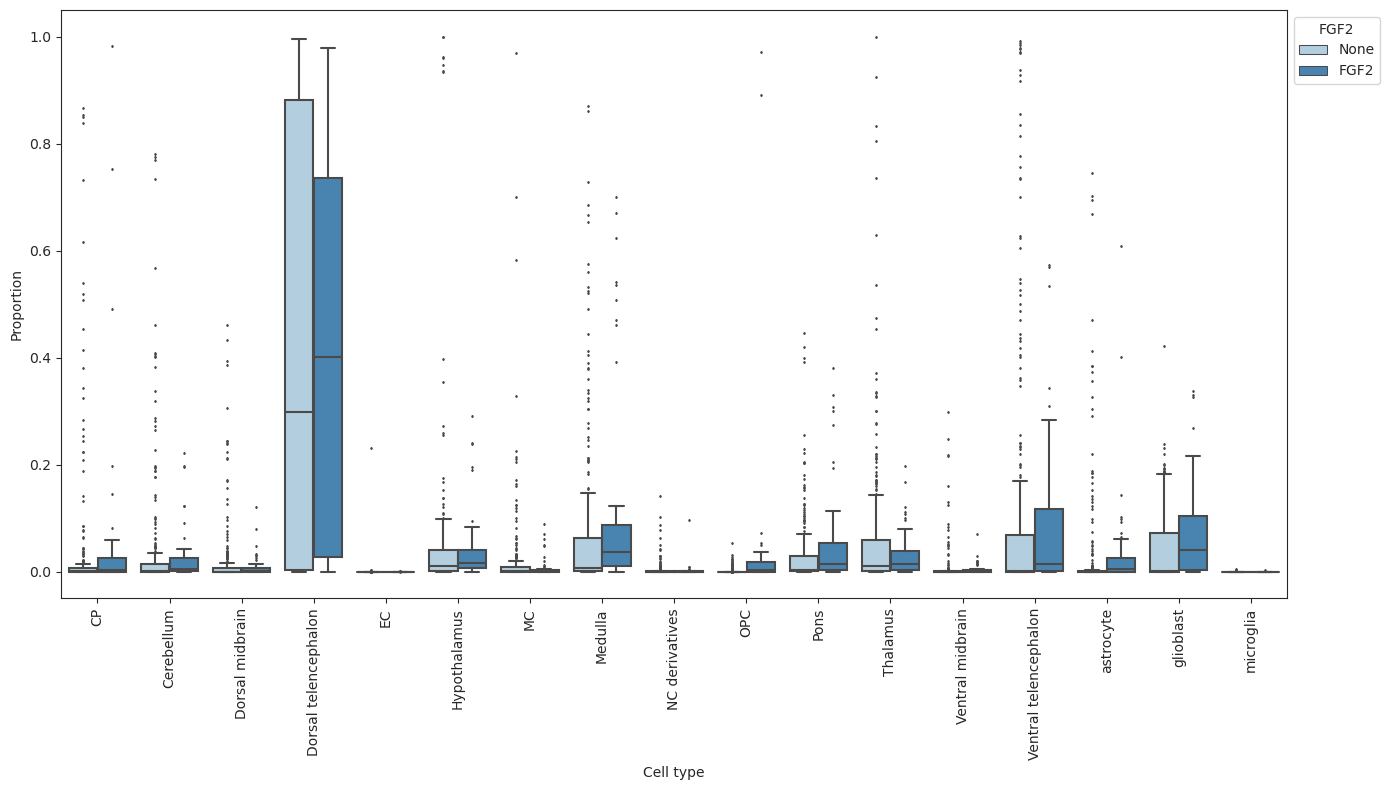

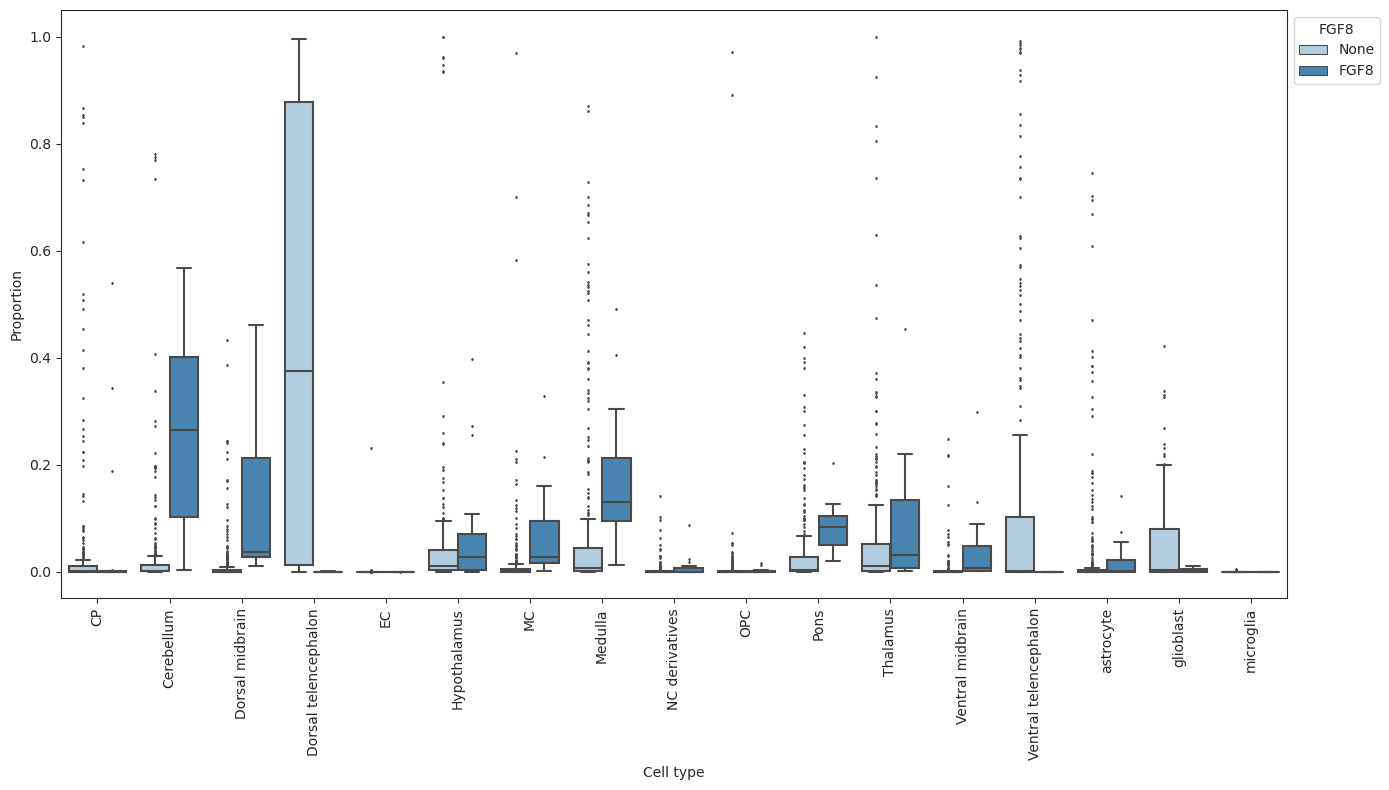

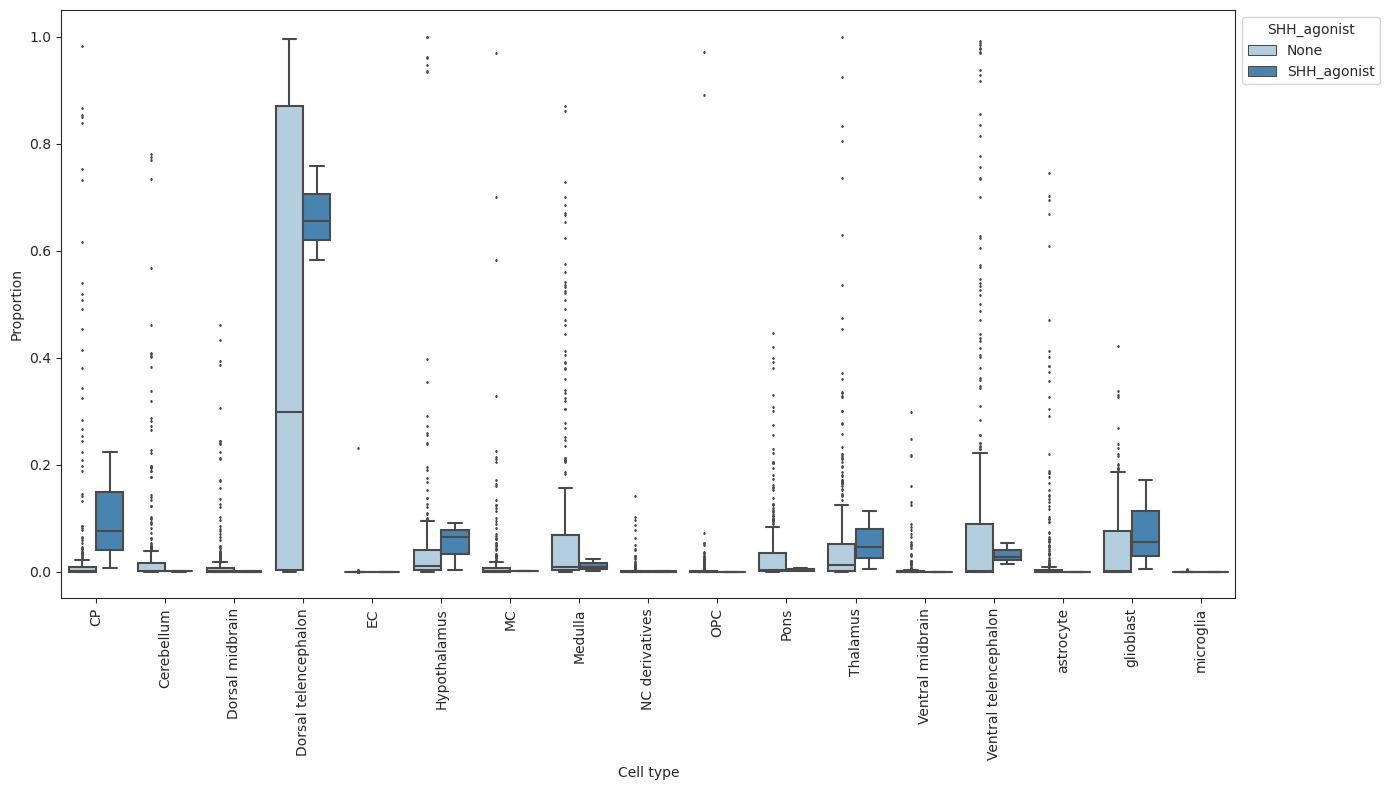

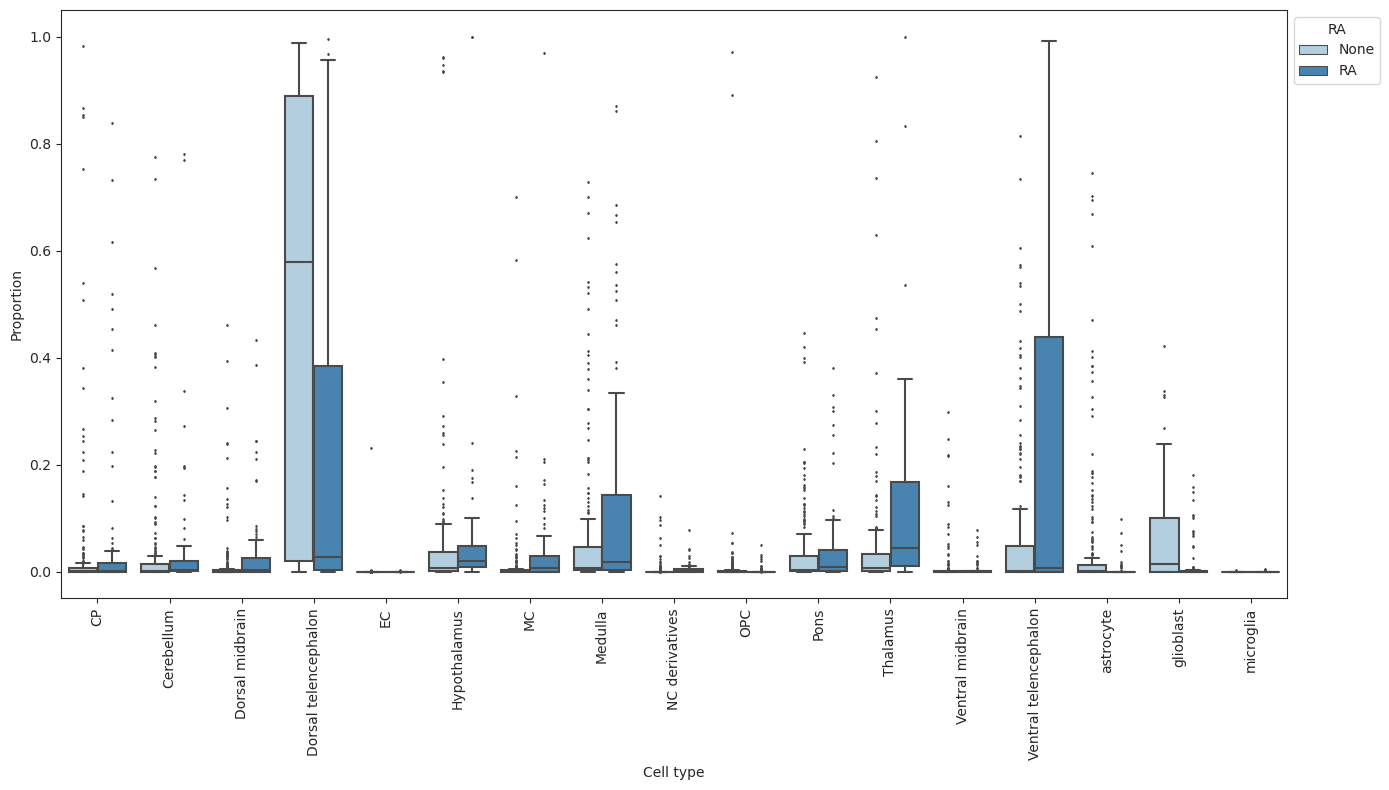

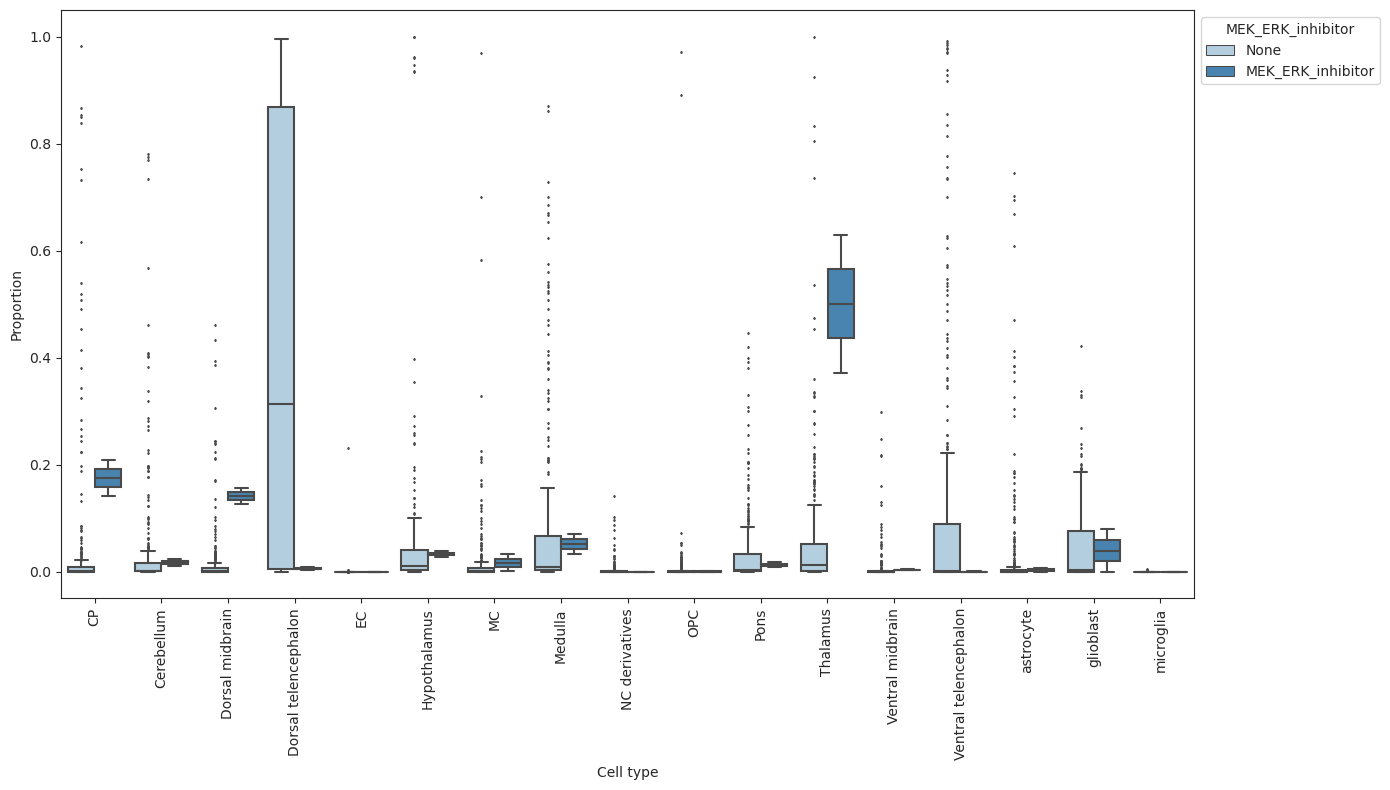

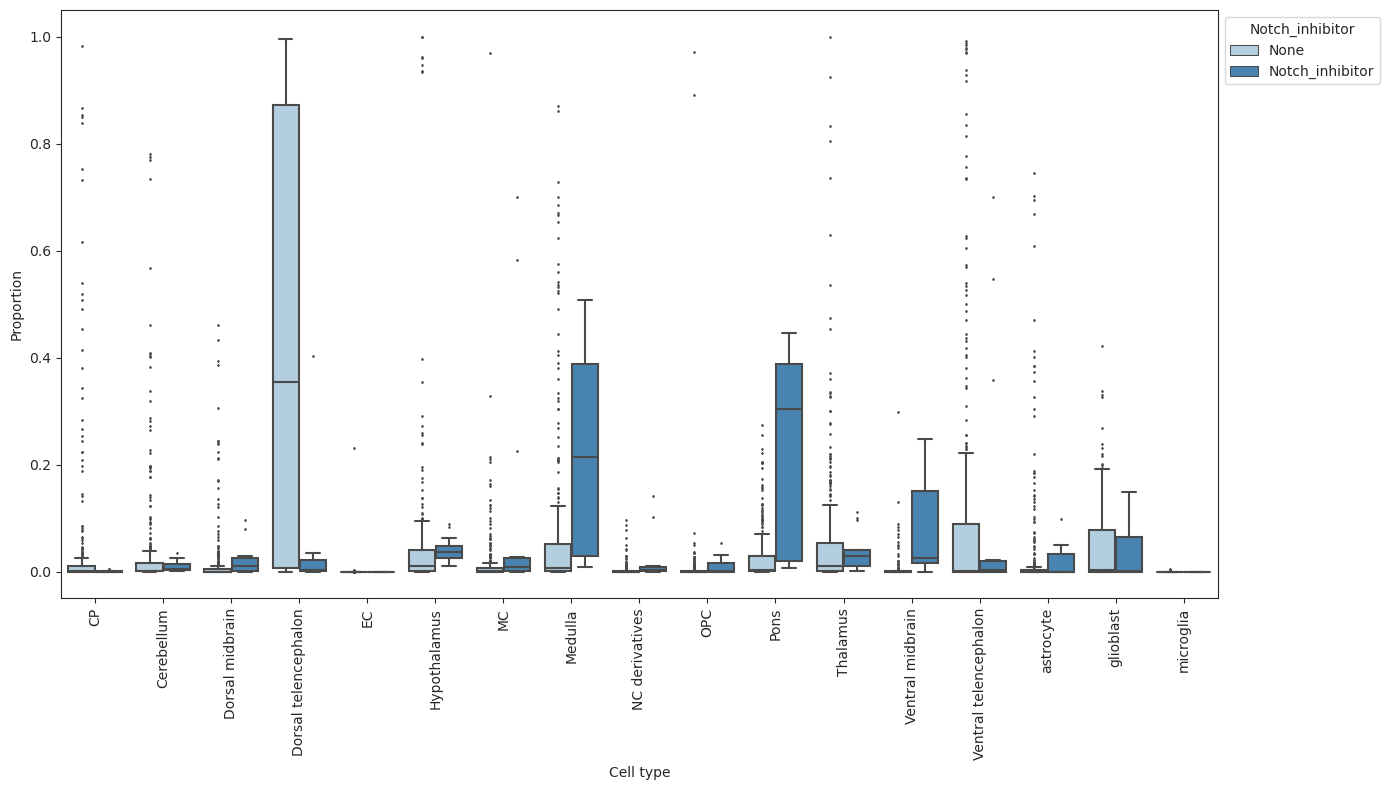

In [19]:
# plot boxplots
for i in range(len(morph_list)):
    pt.pl.coda.boxplots(sccoda_data_reg, modality_key="coda", feature_name=morph_list.loc[i][0], figsize=[14,8])
    plt.savefig(fname = output + 'plots/' + date + morph_list.loc[i][0] + '_scCODA_boxplot_region.pdf', format='pdf', bbox_inches='tight')

## Running the model

In [4]:
# Load the prepared data
sccoda_data_reg = mu.read_h5mu(os.path.join(path, 'scCODA_load_model_organoid_all_morphogens_bio-sample_region'))
sccoda_data_reg

MuData object with n_obs × n_vars = 1677012 × 36859
  2 modalities
    rna:	1676702 x 36842
      obs:	'assay_sc', 'assay_differentiation', 'assay_type_differentiation', 'bio_sample', 'cell_type', 'id', 'organ', 'organoid_age_days', 'publication', 'doi', 'batch', 'snapseed_scpoli_level_1', 'snapseed_scpoli_level_12', 'snapseed_scpoli_level_123', 'snapseed_scpoli_level_1234', 'snapseed_scpoli_level_12345', 'ECM', 'ROCK_inhibitor', 'BMP_activator', 'TGF_B_activator', 'TGF_B_inhibitor', 'BMP_inhibitor', 'WNT_activator', 'WNT_inhibitor', 'EGF', 'FGF2', 'FGF8', 'SHH_agonist', 'RA', 'MEK_ERK_inhibitor', 'Notch_inhibitor', 'ECM_raw', 'ROCK_inhibitor_raw', 'BMP_activator_raw', 'TGF_B_activator_raw', 'TGF_B_inhibitor_raw', 'BMP_inhibitor_raw', 'WNT_activator_raw', 'WNT_inhibitor_raw', 'EGF_raw', 'FGF2_raw', 'FGF8_raw', 'SHH_agonist_raw', 'RA_raw', 'MEK_ERK_inhibitor_raw', 'Notch_inhibitor_raw', 'manual_annot_ct', 'manual_annot_ct_fine', 'manual_annot_region', 'scCODA_region', 'final_class', 'scCODA_sample_id'
      var:	'ensembl', 'gene_symbol'
    coda:	310 x 17
      obs:	'ECM', 'ROCK_inhibitor', 'BMP_activator', 'TGF_B_activator', 'TGF_B_inhibitor', 'BMP_inhibitor', 'WNT_activator', 'WNT_inhibitor', 'EGF', 'FGF2', 'FGF8', 'SHH_agonist', 'RA', 'MEK_ERK_inhibitor', 'Notch_inhibitor', 'bio_sample'
      var:	'n_cells'

In [5]:
# Run scCODA with each cell type (region) as the reference
cell_types = sccoda_data_reg["coda"].var.index
morph_region = morph_list.squeeze()[0]+'_'+cell_types # combining the info from the region and covariate (morphogen)
for i in range(1, len(morph_list)):
    temp = morph_list.squeeze()[i]+'_'+cell_types
    morph_region = morph_region.append(temp)
results_cycle = pd.DataFrame(index=morph_region, columns=["times_credible"]).fillna(0) 
cred_list = {}

In [6]:
cell_types

Index(['CP', 'Cerebellum', 'Dorsal midbrain', 'Dorsal telencephalon', 'EC',
       'Hypothalamus', 'MC', 'Medulla', 'NC derivatives', 'OPC', 'Pons',
       'Thalamus', 'Ventral midbrain', 'Ventral telencephalon', 'astrocyte',
       'glioblast', 'microglia'],
      dtype='object', name='scCODA_region')

In [ ]:
for ct in cell_types:
    print(f"Reference: {ct}")

    # Run inference
    sccoda_data_all = sccoda_model.prepare(sccoda_data_reg, 
                                           modality_key="coda", 
                                           formula="ECM + ROCK_inhibitor + BMP_activator + TGF_B_activator + TGF_B_inhibitor + BMP_inhibitor + WNT_activator + WNT_inhibitor + EGF + FGF2 + FGF8 + SHH_agonist + RA + MEK_ERK_inhibitor + Notch_inhibitor", 
                                           reference_cell_type=ct)
    sccoda_model.run_nuts(sccoda_data_all, modality_key="coda")
    
    # Select credible effects
    cred_eff = sccoda_model.credible_effects(sccoda_data_all, modality_key="coda")
    cred_eff.index = cred_eff.index.get_level_values(0)+ "_"+ cred_eff.index.get_level_values(1) # combined cell type and morphogen
    cred_eff.index = cred_eff.index.str.replace('\[.*\]', '') # makes it nicer to read
    with open(os.path.join(output, 'cred_eff.pickle_'+ct), 'wb') as handle:
        pickle.dump(cred_eff, handle, protocol=pickle.HIGHEST_PROTOCOL)

    # add up credible effects
    results_cycle["times_credible"] += cred_eff.astype("int")
    
    df_cred = sccoda_model.get_effect_df(sccoda_data_all, modality_key="coda")
    df_cred.reset_index(inplace=True)
    df_cred = df_cred[df_cred["Final Parameter"]!=0.0]
    # save the credible effects
    df_cred.to_csv(os.path.join(output,date+ct+'_scCODA_credible_change_bio_sample_final_region.csv')) 

    fig, ax = plt.subplots(figsize=(13, 6), constrained_layout=True)
    sns.barplot(data=df_cred, 
                x="Cell Type", 
                y="log2-fold change", 
                hue="Covariate",
               palette = palette)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
    ax.legend(loc='upper right', bbox_to_anchor=(1.4,1), ncol=1)
    change_width(ax, .25)
    plt.savefig(fname=output+'scCODA_credible_effect_morphogens_ref_'+ct+'_region_bio_sample_LFC.pdf',format='pdf')
    labels = ax.get_xticklabels()

Reference: CP


Zero counts encountered in data! Added a pseudocount of 0.5.

sample:  60%|██████    | 6655/11000 [2:07:01<1:26:54,  1.20s/it, 1023 steps of size 4.40e-03. acc. prob=0.96]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)

sample: 100%|██████████| 11000/11000 [3:33:49<00:00,  1.17s/it, 1023 steps of size 4.40e-03. acc. prob=0.96] 


Reference: Cerebellum


sample:  33%|███▎      | 3673/11000 [1:05:52<2:23:38,  1.18s/it, 1023 steps of size 5.56e-03. acc. prob=0.89]

## Plotting the data

In [ ]:
cred_list = {}
morph_region = []
for i in range(len(cell_types)):
    for j in range(len(morph_list)):
        temp = cell_types[i]+'_'+morph_list[j]
        morph_region.append(temp)
results_cycle = pd.DataFrame(index=morph_region)
res_LFC=pd.DataFrame(index=morph_region)

In [6]:
for ct in cell_types:
    df_cred=pd.read_csv(os.path.join(path,'230630_'+ct+'_scCODA_credible_change_bio_sample_final_region.csv'))
    df_cred = df_cred.rename(columns={"Cell Type": 'Region'})
    df_cred['Morphogens'] = df_cred['Covariate'].str.split('.',1,expand=True)[1]
    df_cred["Morphogens"] = df_cred["Morphogens"].astype('category')
    df_cred["Region_Morphogen"]=df_cred['Region']+'_'+df_cred['Morphogens'].astype('str')
    df_cred['Reference:'+ct]=1
    
    results=df_cred[['Region_Morphogen','Reference:'+ct]]
    results.index = results['Region_Morphogen']
    del results['Region_Morphogen']
    results_cycle = results_cycle.add(results, fill_value=0)
    
    df_cred['Reference:'+ct+'_LFC']=df_cred['log2-fold change']
    res=df_cred[['Region_Morphogen','Reference:'+ct+'_LFC']]
    res.index = res['Region_Morphogen']
    del res['Region_Morphogen']
    res_LFC = res_LFC.add(res, fill_value=0)
    
    cred_list.update({ct:df_cred})

/tmp/ipykernel_81041/2521591939.py:4: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df_cred['Morphogens'] = df_cred['Covariate'].str.split('.',1,expand=True)[1]
/tmp/ipykernel_81041/2521591939.py:4: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df_cred['Morphogens'] = df_cred['Covariate'].str.split('.',1,expand=True)[1]
/tmp/ipykernel_81041/2521591939.py:4: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df_cred['Morphogens'] = df_cred['Covariate'].str.split('.',1,expand=True)[1]
/tmp/ipykernel_81041/2521591939.py:4: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  df_cred['Morphogens'] = df_cred['Covariate'].str.split('.',1,expand=True)

In [7]:
results_cycle.fillna(0, inplace=True)
results_cycle

,Reference:CP,Reference:Cerebellum,Reference:Dorsal midbrain,Reference:Dorsal telencephalon,Reference:EC,Reference:Hypothalamus,Reference:MC,Reference:Medulla,Reference:NC derivatives,Reference:OPC,Reference:Pons,Reference:Thalamus,Reference:Ventral midbrain,Reference:Ventral telencephalon,Reference:astrocyte,Reference:glioblast,Reference:microglia
CP_BMP_activator,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
CP_BMP_inhibitor,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CP_ECM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CP_EGF,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CP_FGF2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
microglia_SHH_agonist,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
microglia_TGF_B_activator,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
microglia_TGF_B_inhibitor,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
microglia_WNT_activator,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [8]:
results_sum = pd.DataFrame(results_cycle.sum(axis=1))
results_sum = results_sum.rename(columns={0: 'times_credible'})
results_sum["pct_credible"] = results_sum["times_credible"]/len(cell_types)
results_sum["is_credible"] = results_sum["pct_credible"] > 0.5
results_sum

,times_credible,pct_credible,is_credible
CP_BMP_activator,16.0,0.941176,True
CP_BMP_inhibitor,0.0,0.000000,False
CP_ECM,0.0,0.000000,False
CP_EGF,0.0,0.000000,False
CP_FGF2,0.0,0.000000,False
...,...,...,...
microglia_SHH_agonist,0.0,0.000000,False
microglia_TGF_B_activator,0.0,0.000000,False
microglia_TGF_B_inhibitor,0.0,0.000000,False
microglia_WNT_activator,0.0,0.000000,False


In [9]:
res_credible = results_sum[results_sum['is_credible']==True]
res_credible.shape

(32, 3)

In [11]:
res_LFC.fillna(0, inplace=True)
res_LFC['is_credible']= results_sum["is_credible"]
res_LFC_T = res_LFC[res_LFC['is_credible']==True]
del res_LFC_T['is_credible']
del res_LFC['is_credible']
res_LFC_T

,Reference:CP_LFC,Reference:Cerebellum_LFC,Reference:Dorsal midbrain_LFC,Reference:Dorsal telencephalon_LFC,Reference:EC_LFC,Reference:Hypothalamus_LFC,Reference:MC_LFC,Reference:Medulla_LFC,Reference:NC derivatives_LFC,Reference:OPC_LFC,Reference:Pons_LFC,Reference:Thalamus_LFC,Reference:Ventral midbrain_LFC,Reference:Ventral telencephalon_LFC,Reference:astrocyte_LFC,Reference:glioblast_LFC,Reference:microglia_LFC
CP_BMP_activator,0.000000,4.605213,4.503115,3.989295,4.538386,4.240816,4.292968,4.463727,4.533474,4.579599,4.493295,4.068114,4.527529,4.453687,4.566229,4.573554,4.560871
CP_MEK_ERK_inhibitor,0.000000,-2.874725,-2.824608,-3.141312,-2.832731,-2.955082,0.000000,-2.550389,-2.805012,-2.839016,-2.620002,0.000000,-2.774570,-2.826873,-2.875079,-2.864676,-2.840312
Cerebellum_BMP_inhibitor,1.278460,0.000000,1.689020,0.888180,1.696327,1.594305,1.656653,1.559158,1.683104,1.716040,1.556536,1.718232,1.673061,1.696788,1.712726,1.704996,1.703628
Cerebellum_FGF8,3.018716,0.000000,2.442374,2.833954,2.925962,2.854355,2.769997,2.397768,2.880906,2.900620,2.170449,2.400657,2.792876,2.951068,2.831404,2.939844,2.903435
Cerebellum_RA,0.843982,0.000000,0.000000,0.549598,1.005574,0.000000,0.000000,0.000000,0.991878,1.011929,0.000000,0.000000,0.969282,0.983320,0.996552,1.028673,1.010521
Dorsal midbrain_BMP_inhibitor,1.124575,1.635424,0.000000,0.773105,1.571592,1.509851,1.538907,1.470064,1.567436,1.578158,1.472524,1.606152,1.553030,1.574871,1.555284,1.563983,1.571620
Dorsal midbrain_FGF8,1.740069,0.000000,0.000000,1.616979,1.839499,1.797867,1.779862,1.542230,1.822261,1.856156,1.267814,1.394556,1.799291,1.885007,1.794635,1.885136,1.845224
Dorsal midbrain_MEK_ERK_inhibitor,0.000000,2.696824,0.000000,2.736488,2.802982,2.514326,2.497797,0.000000,2.849435,2.788530,2.534548,0.000000,2.694422,2.786539,2.818196,2.789881,2.805724
Dorsal midbrain_RA,1.406531,1.130383,0.000000,0.912929,1.282368,1.206636,1.239686,0.000000,1.253997,1.290119,0.000000,0.000000,1.207724,1.219478,1.249292,1.298877,1.281852
Dorsal telencephalon_BMP_inhibitor,-2.621065,-2.632381,-2.529911,0.000000,-2.518319,-2.411309,-2.529929,-2.556720,-2.520405,-2.524871,-2.570706,-2.464610,-2.535084,-2.460499,-2.517353,-2.473550,-2.527488


In [19]:
df = pd.DataFrame(res_LFC.mean(axis=1))
df['is_credible']= results_sum["is_credible"]
df.loc[df['is_credible']==False, 0]=0
df[df['is_credible']==False][0].value_counts()
del df['is_credible']

In [20]:
# make a multiindex 
arrays = [[item[0] for item in res_LFC.index.str.split('_',1)],
         [item[1] for item in res_LFC.index.str.split('_',1)]]
index = pd.MultiIndex.from_arrays(arrays, names=('Region', 'Morphogen'))
df.index = index
df

/tmp/ipykernel_81041/4267013816.py:2: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  arrays = [[item[0] for item in res_LFC.index.str.split('_',1)],
/tmp/ipykernel_81041/4267013816.py:3: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  [item[1] for item in res_LFC.index.str.split('_',1)]]


0
Region    Morphogen                
CP        BMP_activator    4.175875
          BMP_inhibitor    0.000000
          ECM              0.000000
          EGF              0.000000
          FGF2             0.000000
...                             ...
microglia SHH_agonist      0.000000
          TGF_B_activator  0.000000
          TGF_B_inhibitor  0.000000
          WNT_activator    0.000000
          WNT_inhibitor    0.000000

[255 rows x 1 columns]

In [23]:
df_res = df.unstack(level=1)
df_res.columns = df_res.columns.droplevel()
df_res

Morphogen,BMP_activator,BMP_inhibitor,ECM,EGF,FGF2,FGF8,MEK_ERK_inhibitor,Notch_inhibitor,RA,ROCK_inhibitor,SHH_agonist,TGF_B_activator,TGF_B_inhibitor,WNT_activator,WNT_inhibitor
Region,,,,,,,,,,,,,,,
CP,4.175875,0.000000,0.000000,0.000000,0.000000,0.000000,-2.330846,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
Cerebellum,0.000000,1.501601,0.000000,0.000000,0.000000,2.589081,0.000000,0.0,0.552430,0.000000,0.0,0.0,0.000000,0.000000,0.0
Dorsal midbrain,0.000000,1.392152,0.000000,0.000000,0.000000,1.521564,2.077394,0.0,0.939992,0.000000,0.0,0.0,0.000000,0.000000,0.0
Dorsal telencephalon,0.000000,-2.376129,-0.211386,0.000000,0.678573,-0.640285,0.000000,0.0,-1.291788,0.000000,0.0,0.0,0.000000,0.000000,0.0
EC,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
Hypothalamus,0.000000,0.000000,-0.704251,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
MC,0.571124,0.000000,0.000000,0.000000,0.000000,0.000000,-2.114446,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0
Medulla,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.601054,0.000000,0.0,0.0,1.055115,1.208162,0.0
NC derivatives,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0


[Text(0.5, 23.38159722222222, 'Morphogens'),
 Text(50.72222222222221, 0.5, 'Brain regions'),
 Text(0.5, 1.0, 'Significant changes in proportions of regions/cell types upon admission of \n certain morphogens (log2 fold change)')]

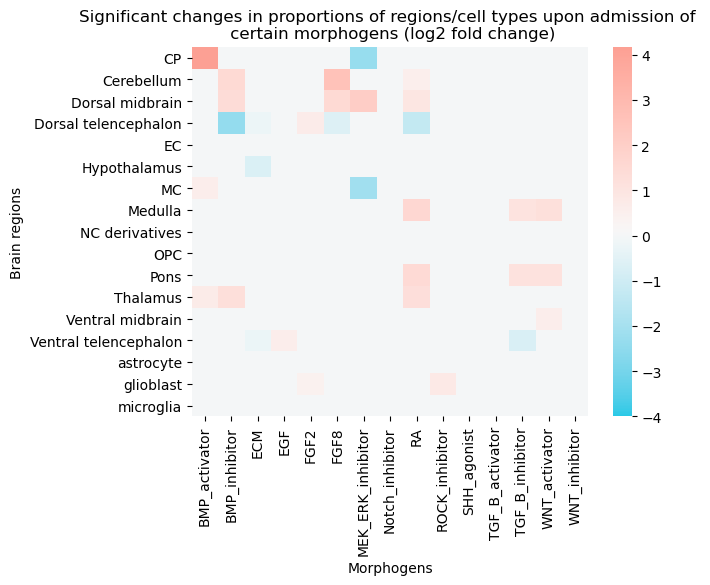

In [75]:
#plt.figure(figsize=(9, 6))
ax=sns.heatmap(df_res, xticklabels=True, yticklabels=True,cmap=my_cmap, vmin=-4)
ax.set(xlabel='Morphogens', 
        ylabel='Brain regions',
       title='Significant changes in proportions of regions/cell types upon admission of \n certain morphogens (log2 fold change)')

In [85]:
df_freq = pd.DataFrame(results_cycle.sum(axis=1))
arrays = [[item[0] for item in df_freq.index.str.split('_',1)],
         [item[1] for item in df_freq.index.str.split('_',1)]]
index = pd.MultiIndex.from_arrays(arrays, names=('Region', 'Morphogen'))
df_freq.index = index
df_freq = df_freq.unstack(level=1)
df_freq.columns = df_freq.columns.droplevel()
df_freq

/tmp/ipykernel_81041/1063399137.py:2: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  arrays = [[item[0] for item in df_freq.index.str.split('_',1)],
/tmp/ipykernel_81041/1063399137.py:3: FutureWarning: In a future version of pandas all arguments of StringMethods.split except for the argument 'pat' will be keyword-only.
  [item[1] for item in df_freq.index.str.split('_',1)]]


Morphogen,BMP_activator,BMP_inhibitor,ECM,EGF,FGF2,FGF8,MEK_ERK_inhibitor,Notch_inhibitor,RA,ROCK_inhibitor,SHH_agonist,TGF_B_activator,TGF_B_inhibitor,WNT_activator,WNT_inhibitor
Region,,,,,,,,,,,,,,,
CP,16.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Cerebellum,0.0,16.0,0.0,0.0,0.0,16.0,0.0,0.0,10.0,0.0,0.0,7.0,0.0,0.0,0.0
Dorsal midbrain,0.0,16.0,0.0,0.0,0.0,15.0,13.0,0.0,13.0,0.0,1.0,2.0,1.0,0.0,0.0
Dorsal telencephalon,2.0,16.0,15.0,0.0,16.0,12.0,0.0,0.0,16.0,0.0,1.0,0.0,0.0,0.0,0.0
EC,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Hypothalamus,0.0,0.0,16.0,7.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0
MC,14.0,0.0,0.0,0.0,0.0,0.0,14.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
Medulla,1.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,15.0,0.0,1.0,0.0,14.0,14.0,0.0
NC derivatives,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


[Text(0.5, 23.38159722222222, 'Morphogens'),
 Text(50.72222222222221, 0.5, 'Brain regions'),
 Text(0.5, 1.0, 'Number of significant changes in proportions of regions/cell types upon \nadmission of certain morphogens ')]

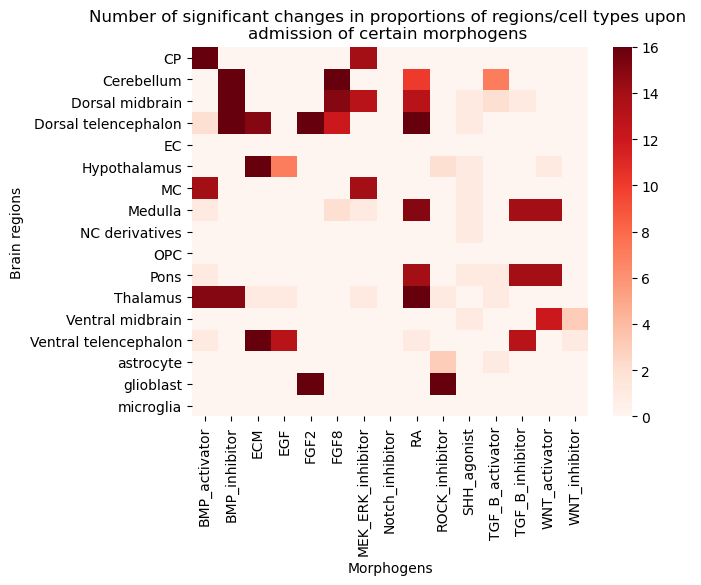

In [91]:
ax=sns.heatmap(df_freq, xticklabels=True, yticklabels=True, cmap='Reds')
ax.set(xlabel='Morphogens', 
        ylabel='Brain regions',
       title='Number of significant changes in proportions of regions/cell types upon \nadmission of certain morphogens ')

## Comparison with glm analysis

In [ ]:
# function that changes width of bars in barpltos
def change_width(ax, new_value) :
    for patch in ax.patches :
        current_width = patch.get_width()
        diff = current_width - new_value

        # we change the bar width
        patch.set_width(new_value)

        # we recenter the bar
        patch.set_x(patch.get_x() + diff * .5)

In [8]:
piv = df_res.pivot(columns='Region').T
piv = piv.mean(axis=1)
piv = piv.reset_index()
piv = piv.rename(columns={'level_0': 'Morphogen', 0: 'log2-fold change'})

In [72]:
piv[piv['log2-fold change']==0]['Region'].value_counts()
# take out the cell types that don't occur in the system

microglia                15
NC derivatives           15
OPC                      15
astrocyte                15
EC                       15
Ventral midbrain         14
Hypothalamus             14
Glioblast                13
Choroid plexus           13
Mesenchyme               13
Medulla                  12
Cerebellum               12
Pons                     12
Ventral telencephalon    12
Thalamus                 12
Dorsal midbrain          11
Dorsal telencephalon     10
Name: Region, dtype: int64

In [ ]:
pivF = piv[(piv['Region']!='EC') & 
    (piv['Region']!='microglia') & 
    (piv['Region']!='NC derivatives') & 
    (piv['Region']!='OPC') & 
    (piv['Region']!='astrocyte')]

In [95]:
pivF.replace(['CP','MC', 'glioblast', 'Dorsal_midbrain', 'Dorsal_telencephalon', 'Ventral_telencephalon'],
                ['Choroid plexus', 'Mesenchyme', 'Glioblast', 'Dorsal midbrain', 'Dorsal telencephalon', 'Ventral telencephalon'], inplace=True)
pivF.replace(['BMP_activator','BMP_inhibitor', 'MEK_ERK_inhibitor', 'ROCK_inhibitor', 'TGF_B_inhibitor', 'WNT_activator', 'WNT_inhibitor', 'SHH_agonist', 'Notch_inhibitor', 'TGF_B_activator'],
             ['BMP activator', 'BMP inhibitor', 'MEK/ERK inhibitor', 'ROCK inhibitor', 'TGF-B inhibitor', 'WNT activator', 'WNT inhibitor', 'SHH agonist', 'Notch inhibitor', 'TGF-B activator'], inplace=True)
pivF['Region'].astype('category')
pivF.sort_values(by=['Region'], inplace=True)
pivF.sort_values(by=['Morphogen'], inplace=True)
pivF['log2-fold change'].astype('float64')

2      0.000000
0      4.175875
12     0.000000
11     0.700865
3      0.000000
         ...   
251    0.000000
249    0.000000
244    0.000000
238    0.000000
243    0.000000
Name: log2-fold change, Length: 180, dtype: float64

In [ ]:
order = pivF['Region'].sort_values().unique()

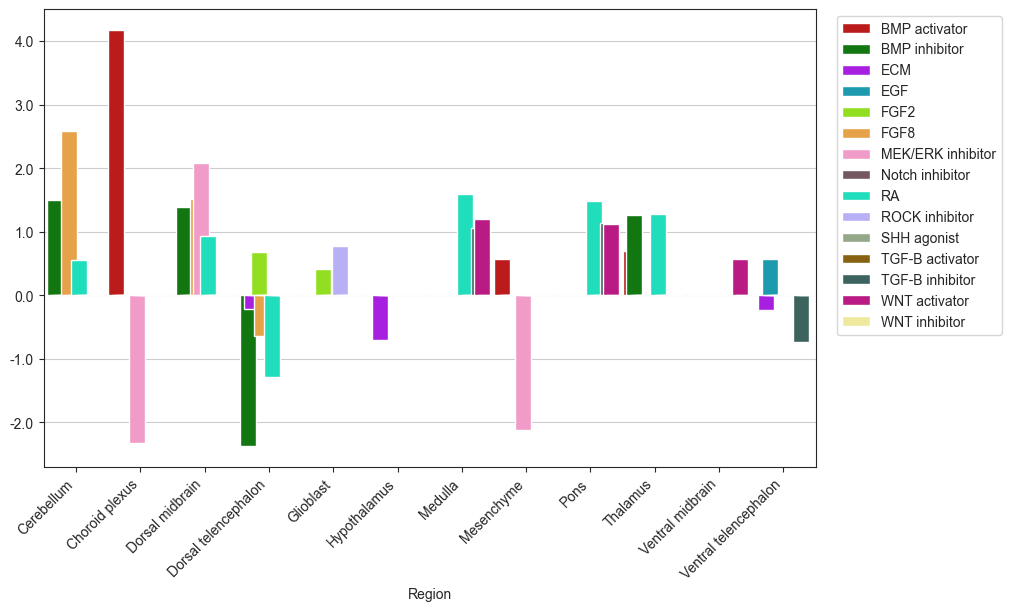

In [97]:
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
sns.set_style("ticks")

sns.barplot(data=pivF, 
            x="Region", 
            y='log2-fold change', 
            hue="Morphogen",
           palette = palette,
           order=order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.legend(loc='upper right', bbox_to_anchor=(1.25,1), ncol=1)
ax.set(ylabel=None)
#ax.xaxis.grid(True)
ax.yaxis.grid(True)
change_width(ax, .25)
ax.yaxis.set_major_formatter(StrMethodFormatter('{x:,.1f}')) # 1 decimal places
plt.savefig(fname=path+'scCODA_compositional_analysis.pdf',format='pdf')

In [41]:
df_glmn1 = pd.read_csv(os.path.join(path, 'glm_comparison/230728_glm_a1_l1se_molecule_coefs.tsv'), sep='\t')
df_glmn1 = df_glmn1.rename(columns={'term': 'Morphogen', 'region_coarse': 'Region'})
df_glmn1 = df_glmn1[df_glmn1['coef']!=0]

df_glmn1.replace(['CP','MC', 'glioblast', 'Dorsal_midbrain', 'Dorsal_telencephalon', 'Ventral_telencephalon'],
                ['Choroid plexus', 'Mesenchyme', 'Glioblast', 'Dorsal midbrain', 'Dorsal telencephalon', 'Ventral telencephalon'], inplace=True)
df_glmn1.replace(['BMP_activator','BMP_inhibitor', 'MEK_ERK_inhibitor', 'ROCK_inhibitor', 'TGF_B_inhibitor', 'WNT_activator', 'WNT_inhibitor', 'SHH_agonist', 'Notch_inhibitor', 'TGF_B_activator'],
             ['BMP activator', 'BMP inhibitor', 'MEK/ERK inhibitor', 'ROCK inhibitor', 'TGF-B inhibitor', 'WNT activator', 'WNT inhibitor', 'SHH agonist', 'Notch inhibitor', 'TGF-B activator'], inplace=True)
df_glmn1['Morphogen'].astype('category')
df_glmn1['Region'].astype('category')
df_glmn1.sort_values(by=['Morphogen'], inplace=True)
df_glmn1['coef'].astype('float64')
df_glmn1

,Morphogen,coef,Region
2,BMP activator,1.472029,Choroid plexus
155,BMP inhibitor,-0.185459,Ventral telencephalon
50,BMP inhibitor,-0.910356,Dorsal telencephalon
125,BMP inhibitor,0.252401,Pons
185,BMP inhibitor,-0.482378,Glioblast
35,BMP inhibitor,0.206929,Dorsal midbrain
95,BMP inhibitor,0.305859,Medulla
20,BMP inhibitor,0.033165,Cerebellum
215,BMP inhibitor,0.079487,Ventral_midbrain
135,ECM,-0.567356,Thalamus


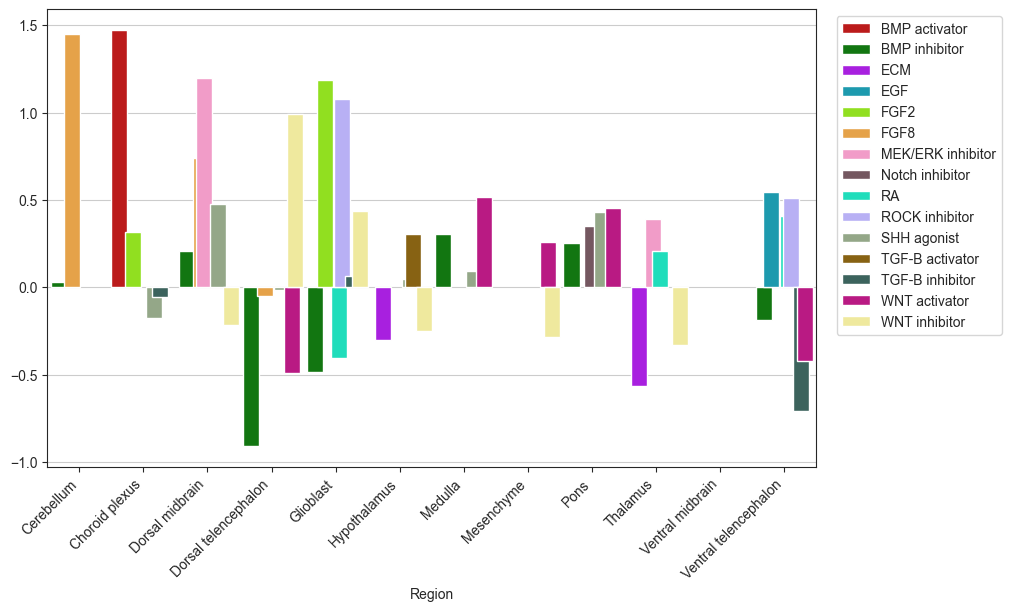

In [49]:
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)
sns.set_style("ticks")

sns.barplot(data=df_glmn1, 
            x="Region", 
            y='coef', 
            hue="Morphogen",
           palette = palette,
           order=order)
ax.set_xticklabels(ax.get_xticklabels(), rotation=45, horizontalalignment='right')
ax.legend(loc='upper right', bbox_to_anchor=(1.25,1), ncol=1)
#ax.xaxis.grid(True)
ax.set(ylabel=None)
ax.yaxis.grid(True)
change_width(ax, .25)